<a href="https://colab.research.google.com/github/SimonTommerup/02805-sgai/blob/main/notebooks/main_notebook10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports used

In [ ]:
!pip install powerlaw
!pip install colour
import pandas as pd
import numpy as np
import re
import nltk
import networkx as nx
import matplotlib.pyplot as plt
import json
import matplotlib.patches as mpatches
import matplotlib.patches as mpatches
import urllib
import powerlaw

from scipy import integrate
from scipy import stats
from fa2 import ForceAtlas2
from collections import Counter
from tqdm import tqdm
from colour import Color


plt.style.use("seaborn")

Mount google drive to quickly access network and data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We can then load the data from the mount and the weighted network generated from this data

In [ ]:
data_path = "drive/MyDrive/SGAI/data_all_merged.csv"
network_path = "drive/MyDrive/SGAI/G_weighted_T_B_removed.gpickle"
df = pd.read_csv(data_path, sep=";")
G_full = nx.read_gpickle(network_path) # Convention: our original weihgted network = G
# The other we'll call B (for backbone)

# Some usefull functions for data extraction
def extract_decoded_used_subreddits(df): 
    encoded_used_subreddits = np.array(df.used_subreddits)
    used_subreddits_list = []
    for l in encoded_used_subreddits:
      l1 = json.loads(l)
      used_subreddits_list.append(l1)
    return used_subreddits_list


def nodes_to_used_subreddits(dataframe, unique=False):
    users = [u for u in dataframe["user"]]
    if unique:
        used_subreddits = [list(set(json.loads(us))) for us in dataframe["used_subreddits"]]
    else:
        used_subreddits = [json.loads(us) for us in dataframe["used_subreddits"]]
    n2us = {}
    for u, us in zip(users, used_subreddits):
      n2us[u] = us
    return n2us





# 1 Motivation
- What is your dataset? **Måske noget ala**
Our presumption is that the subreddits which a user has top-comments on somewhat reflects that user's typical interests. Therefore, we hope to somewhat model common interests between users! 

- Why did you choose this/these particular dataset(s)?
- What was your goal for the end user's experience?

- Criticize how we link users...

### 1.1 Our dataset

Our dataset was created by scraping the two subreddits r/DonaldTrump and r/JoeBiden on https://www.reddit.com. The dataset was assembled into a CSV-file with 2697 rows and 5 columns. 

Each row is a unique reddit user. 

The table below shows the five attributes in the columns along with their datatype in the CSV-file:


| user_name |  from_subreddit |  comment |  used_subreddits | comment_sentiment |
|---|---|---|---|---|
| string  | string  | string  |  JSON-encoded list |  float |

1. `user_name` is the unique reddit user name. 
2. `from_subreddit` is the subreddit from which the user was scraped and can take values `trump` for r/DonaldTrump and `biden` for r/JoeBiden.
3. `comment` is a longer string holding the user's text comment. 
4. `used_subreddits` is a list of maximally 50 subreddits which are not necessarily unique. 
5. `comment_sentiment` is a float value indicating the sentiment in the comment on a scale from 0 to 10 where 10 is the happiest.



### 1.2 Preview of the data set

To illustrate section 1.1, below is the first three entries of the data set: 

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/SGAI/data_all_merged.csv", ";")

df.head(3)

,user,from_subreddit,comment,used_subreddits,comment_sentiment
0,jackaust537,trump,I know a lot of people who hate on Trump suppo...,"[""Disney Vacation: Terrible illustrations foun...",NaN
1,TheCookie_Momster,trump,"I recall seeing thousands of Obama stickers, n...","[""Am I the Asshole? "", ""Am I the Asshole? "", ""...",NaN
2,phoenix335,trump,You can tell this is a completely fabricated s...,"[""Men's Rights :: Advocating for the social an...",NaN


### 1.3 Building our dataset

We used the Reddit API (https://www.reddit.com/dev/api/) through the PRAW wrapper (https://praw.readthedocs.io/en/latest/) to conduct the scraping.

In summary our data set was built by:

1. Collecting unique thread and comment ids.
2. Requesting and scraping comments by the unique ids.
3. Storing the scraped data in CSV files.
4. Merging the data into a final CSV file.
5. Computing and inserting comment sentiments.

In the two subreddits r/DonaldTrump and r/JoeBiden we chose to go through 48 all time top comments in 36 threads. 

Topcomments are the comments that are the most upvoted through the subreddits existence. We selected to look at the top comments as we hypothesized that these reflect the subreddits' users well. We mean that they are representative of what we may term ideal users in the given subreddit. The subreddit itself selects these comments as content that is proper to the subreddit. Also there is a practical issue: Most upvoted comments will likely contain a statement of some sort and not just be an emoji or single words. 

The most challenging part of the data collecting was to deal with a two second delay in each API request and further we ran into a number of server errors on Reddit's servers because of the long run time. Therefore we had to come up with a way to divide the data collection into manageable chunks. This was done by first collecting all the unique thread and comment ids that we wanted to look at and then requesting these ids directly through the api. In this way we split the data collection into six manageable chunks (each took about six or seven hours to scrape due to the delay) with half Trump thread and half Biden threads. The collected data was then saved to separate CSV files. 

Also we realized that there were some Trump threads were there were not quite enough comments on, so we had to expand the data with some Trump user injections in order to balance the data set betwee Trump and Biden users. This was possible as we knew which thread ids we had already gone through and as such we could carry on from where we left.

After completing the collection of all the chunks, we merged all the collected data into a final CSV file to use for our project.

The Python implementation of our data building can be seen in our GitHub repository (https://github.com/SimonTommerup/02805-sgai) as mainly `data_generator.py` where the actual scraping takes place and in part `utils.py` where the function `get_data_ids` was built to collect the thread and comment ids.

### 1.4 Why we chose this dataset

### 1.5 Goal for the end user's experience

# 2 Basic stats. Let's understand the dataset better
- Write about your choices in data cleaning and preprocessing
- Write a short section that discusses the dataset stats (here you can recycle the work you did for Project Assignment A) **But leave network stats (#nodes, #edges degree...) to next section!**

INSPIRATION:

How many of the users has commented on 50 subreddits?

172 users (6.38%) has under 50 comments on other subreddits
k_min: 1, k_max: 50


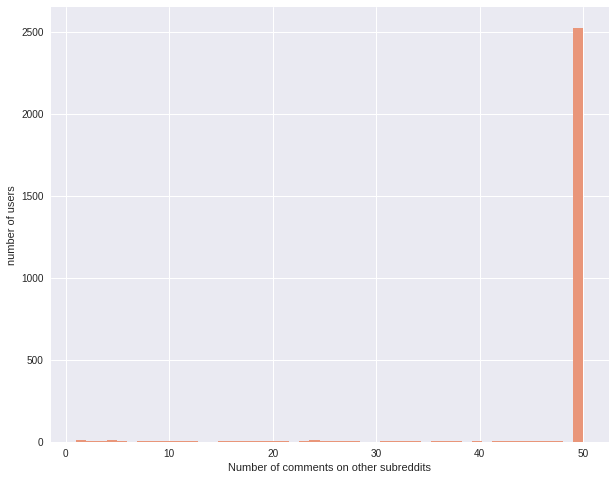

In [ ]:
used_subreddits = np.array(df.used_subreddits)
used_subreddits_list = []
for i, l in enumerate(used_subreddits):
    l1 = json.loads(l)
    used_subreddits_list.append(l1)


lens = [len(li) for li in used_subreddits_list]
limit=50
lens_lows = [len(li) for li in used_subreddits_list if len(li) < limit]


print(f"{len(lens_lows)} users ({round(len(lens_lows)/len(lens)*100,2)}%) has under {limit} comments on other subreddits")


bins = 50
k_min = np.min(lens)
k_max = np.max(lens)
print(f"k_min: {min(lens)}, k_max: {max(lens)}")
count, bins = np.histogram(lens, bins=bins)
plt.subplots(figsize=(10,8))  

# Hist plot
#plt.hist(bins[:len(bins)-1], count, color="darksalmon")
plt.hist(lens, bins, color="darksalmon")

plt.xlabel('Number of comments on other subreddits')
plt.ylabel('number of users')
plt.show()


How diverse are they? (i.e. how many unique subreddits

172 users (6.38%) has under 50 comments on other subreddits
k_min: 1, k_max: 47


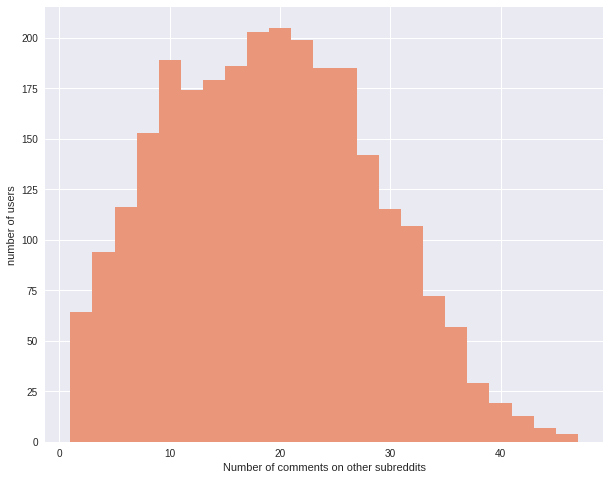

In [ ]:
used_subreddits = np.array(df.used_subreddits)
used_subreddits_list = []
for i, l in enumerate(used_subreddits):
    l1 = json.loads(l)
    used_subreddits_list.append(l1)


lens = [len(set(li)) for li in used_subreddits_list]
limit=50


print(f"{len(lens_lows)} users ({round(len(lens_lows)/len(lens)*100,2)}%) has under {limit} comments on other subreddits")


bins = max(lens)//2
k_min = np.min(lens)
k_max = np.max(lens)
print(f"k_min: {min(lens)}, k_max: {max(lens)}")
count, bins = np.histogram(lens, bins=bins)
plt.subplots(figsize=(10,8))  

# Hist plot
#plt.hist(bins[:len(bins)-1], count, color="darksalmon")
plt.hist(lens, bins, color="darksalmon")

plt.xlabel('Number of comments on other subreddits')
plt.ylabel('number of users')
plt.show()


In [ ]:
# ARGUMENTER FOR...


In [ ]:
from_subreddits = np.array(df.from_subreddit)

bidens = 0
trumps = 0
for i in range(len(from_subreddits)):
  if from_subreddits[i] == "trump":
    if "biden" in used_subreddits[i]:
      bidens+=1
  elif from_subreddits[i] == "biden":
    if "trump" in used_subreddits[i]:
      trumps+=1
  else:
    print("error")


In [ ]:
print(bidens, trumps)

18 8


In [ ]:
url = "https://frontpagemetrics.com/top"
response = urllib.request.urlopen(url)
html = response.read()
rawtop100 = re.findall("r\/\w*", html.decode("utf-8"))

# First hit is just "r/" 
rawtop100 = raw_top100[1:]

# Subreddits appear twice in the html 
top100 = []
for subreddit in rawtop100:
  if subreddit not in top100:
    top100.append(subreddit)

grid_view = []
for idx in range(10):
  grid_view.append( top100[10*idx:10*idx+10] )

df = pd.DataFrame(data=grid_view, columns=[c for c in range(10)])
df

,0,1,2,3,4,5,6,7,8,9
0,r/announcements,r/funny,r/AskReddit,r/gaming,r/aww,r/Music,r/pics,r/science,r/worldnews,r/videos
1,r/todayilearned,r/movies,r/news,r/Showerthoughts,r/EarthPorn,r/gifs,r/IAmA,r/food,r/askscience,r/Jokes
2,r/explainlikeimfive,r/LifeProTips,r/Art,r/books,r/mildlyinteresting,r/DIY,r/nottheonion,r/sports,r/blog,r/space
3,r/gadgets,r/Documentaries,r/GetMotivated,r/photoshopbattles,r/tifu,r/television,r/UpliftingNews,r/listentothis,r/InternetIsBeautiful,r/philosophy
4,r/history,r/dataisbeautiful,r/Futurology,r/WritingPrompts,r/OldSchoolCool,r/nosleep,r/personalfinance,r/memes,r/creepy,r/TwoXChromosomes
5,r/technology,r/AdviceAnimals,r/wholesomememes,r/Fitness,r/interestingasfuck,r/politics,r/WTF,r/travel,r/bestof,r/BlackPeopleTwitter
6,r/oddlysatisfying,r/leagueoflegends,r/facepalm,r/me_irl,r/lifehacks,r/pcmasterrace,r/relationship_advice,r/Minecraft,r/NatureIsFuckingLit,r/Whatcouldgowrong
7,r/dankmemes,r/Tinder,r/BikiniBottomTwitter,r/trippinthroughtime,r/PS4,r/AnimalsBeingBros,r/tattoos,r/photography,r/nba,r/AnimalsBeingJerks
8,r/woahdude,r/dadjokes,r/reactiongifs,r/FoodPorn,r/Overwatch,r/Unexpected,r/PewdiepieSubmissions,r/nextfuckinglevel,r/buildapc,r/gardening
9,r/boardgames,r/instant_regret,r/WatchPeopleDieInside,r/mildlyinfuriating,r/ContagiousLaughter,r/pokemon,r/Parenting,r/gonewild,r/programming,r/AnimalsBeingDerps


# 3 Tools, theory and analysis. Describe the process of theory to insight
In this section we analyze the above presented data using network science tools and data analysis strategies.


## 3.1 Creating network and initial analysis



**BEMÆRK DENNE SECTION SKAL MÅSKE LIGE SØRGES FOR STEMMER OVERENS MED MOTIVATION OSV.. TING DER KAN SKRIVES HER, KUNNE SIKKERT OGSÅ SKRIVES OVENFOR I 1_MOTIVATION**

As mentioned and discussed in previous sections, we will be investigating active users on the subreddit pages of the two 2020 presidential candidates of USA [Trump](https://www.reddit.com/r/donaldtrump/) and [Biden](https://www.reddit.com/https://www.reddit.com/r/joebiden/). We are interested in examining how users connect based on other subreddits which they have top comments on. 

To do this we will first create a bipartite network of users and subreddits. Subsequently we look at the projection of users as a weighted network, to investigate the users specifically.

Initially we will **Introduction..., then 3.2 then 3.3. then 3.4. (overview!)**.




### 3.1.1 The bipartite network
To describe the bipartite network of users and subreddits, we have 
- $U$, the set of users
- $M$, the two 'main subreddits', which are the [Trump](https://www.reddit.com/r/donaldtrump/) and [Biden](https://www.reddit.com/https://www.reddit.com/r/joebiden/) subreddits.
- $S^u$, the set of subreddits which $u \in U$ has commented on, excluding subreddits in $M$. 
- $S$, the set of all subreddits commented on by all users, ${\bigcup_{u \in U} S^u}$. 

We can assemble this data into a undirected bipartite network $G_{bi}$ with two distjoint sets of nodes $U$ and $S$. A user $u \in U$ is connected to subreddit $s \in S$ if $s \in S^u$. This means that we have a network $G_{bi}$ where a user has a connection to all subreddits which it have commented on, excluding the trump and biden subreddit. And these subreddits are further connected to every other user, which has also commented on this subreddit. From this point on, we will write user and node interchangeably.

Note that we do not link users based on the main subreddits as this would otherwise link all users found on the trump-subreddit to each other, and similarly all users found on the biden-subreddit. First of all it would lead towards a biased (high) modularity for separating the network into two communities based on where they were found (trump or biden subreddit). Second, we are interested in investigating which *other* subreddits than the two main ones, the users have in common. Thus, we exclude these when connecting two users.



### 3.1.2 Building a weighted network of users
In order to obtain the network of users, a projection of $G_{bi}$ is considered. To preserve as much information from $G_{bi}$ as possible, links between users are scaled based on the number of common subreddits, which both users have top comments on. 

Specifically, users $u_i, u_j \in U$ are connected with weight equal to the size of $S^{u_i}\cap S^{u_j}$.

We will create the weighted network from an implicit representation of $G_{bi}$, by acessing the data directly from the pandas dataframe

In [ ]:
def get_ids_of_users_with_common_subreddits(user_id, users, used_subreddits):
    users_with_common_subreddits = []
    for other_user_id in range(len(users)):
        if other_user_id != user_id:  # Skip connection to self
            for subr in used_subreddits[user_id]:
                if subr in used_subreddits[other_user_id]:
                    users_with_common_subreddits.append(other_user_id)
                    break
    return users_with_common_subreddits


def get_common_subreddits(user_id, other_user_id, used_subreddits):
    common_subreddits = [subreddit for subreddit in used_subreddits[user_id] if subreddit in used_subreddits[other_user_id]]
    return common_subreddits

  
def create_graph(users, used_subreddits, from_subreddits, commons_2_ignore, n_required_subreddits=1):
    G = nx.Graph()
    # Loop through all users
    for user_id in tqdm(range(len(users))):
        # Add a node for EVERY user in data set 
        G.add_node(users[user_id], from_subreddit=from_subreddits[user_id])

        # Get all other users with atleast one other subreddit in common, 
        other_users_id = get_ids_of_users_with_common_subreddits(user_id, users, used_subreddits)
        for other_user_id in other_users_id:
            # Save all UNIQUE common subreddits as edge property if constraints are satisfied
            common_subreddits = get_common_subreddits(user_id, other_user_id, used_subreddits)
            common_subreddits = list(set(common_subreddits))
            # Remove the two main subreddits (trump and biden) as common subreddit.
            common_subreddits = [subreddit for subreddit in common_subreddits if subreddit not in commons_2_ignore]
            # Only link edges if #common_subreddits > n_required_subreddits
            if len(common_subreddits) >= n_required_subreddits:
                G.add_edge(users[user_id], users[other_user_id], common_subreddits=(common_subreddits), 
                           weight=len(common_subreddits))
    return G


# Extract data to more effeciently loop through it rather than looping through a df
used_subreddits, users, from_subreddits  = extract_decoded_used_subreddits(df), np.array(df.user), np.array(df.from_subreddit)

commons_2_ignore = ['trump', 'biden', ""]

# Create graph
#G_full = create_graph(users, used_subreddits, from_subreddits, commons_2_ignore, n_required_subreddits=1)

Initially, we look closer at the size of the connected components of the network

In [ ]:
# Extract the largest connected components
CCs = list(nx.connected_components(G_full))

# Print lengths
comps = [list(comp) for comp in CCs]
print("Sizes of the connected components: ", [len(comp) for comp in comps])

Sizes of the connected components:  [2669, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


It reveals that almost the entire network is connected, and only 28 users are disconnected from the rest of the network. These users are inspected for which type of subreddits they comment on:

In [ ]:
# Extract users which are not in largest component 
removed_users = [comp[0] for comp in comps if len(comp) == 1]
removed_users_subreddits_with_lengths = []

# Print their info of used subreddits:
for i in range(len(users)):
  if users[i] in removed_users:
    res_string = ""
    for s in set(used_subreddits[i]):
      if len(s) > 10:
        print_s = s[:10] + "..."
      else:
        print_s = s
      res_string+=print_s + ": " + str(len([n for n in used_subreddits[i] if n == s])) + "  "
    removed_users_subreddits_with_lengths.append(res_string)

df_removed_users = pd.DataFrame({'User':removed_users,
                                 'Used subreddits w. counts':removed_users_subreddits_with_lengths
                                })
df_removed_users

,User,Used subreddits w. counts
0,Trouble_Short,trump: 1
1,ArcEchoFive,trump: 4
2,Future_Cup_2762,biden: 50
3,jd33d,biden: 24
4,Connorskath,biden: 1
5,Carmar10,biden: 1
6,hamel7777,biden: 1
7,Words-Always-Matter,biden: 50
8,Popular_Vote_1001,trump: 1
9,Rocco112263,biden: 10 trump: 18


The table shows the 28 users which have no links in the network. For each user, their ``used_subreddits`` are printed along with how many of their top 50 comments where on this specific subreddit. This shows some different characteristics of these users.

First, we see that there are some users which are very inactive on reddit with commenting. They have only commented a few times on any subreddit - and of course these are primarily at biden and trump, as we initially found the user by looking at their comment on the trump or biden subreddit. Thus, as we do not link according to these two main subreddits as mentioned above, these users have no links.

Then, there is a group of users who are somewhat active on a few seemingly less popular subreddits, which none of the other 2697 users have top comments on.

Finally, there is a group of people who are extremely active on the trump and especially biden subreddits, as their top 50 comments only happens to be on these two specific subreddits. 

As the purpose of this work is to investigate *other* common interests between trump/biden-subreddit users, these persons are not considered in the rest of the network analysis. Therefore, we extract the large connected component.



In [ ]:
# Use largest component as network
nodes_of_LC = (max(CCs, key=len))
G = G_full.subgraph(nodes_of_LC).copy()

As supplement to this work, it would be interesting to further investigate and retrieve more data on these very comitted/dedicated trump or biden users who primarily comment on these two subreddits.

### 3.1.3 Basic stats and properties of the weighted network



#### 3.1.3.1 Motive


We want an initial impression of the weighted network by calculating some measures
- Number of nodes
- Number of edges
- Min weighted and unweighted degree
- Max weighted and unweighted degree
- Median of weighted and unweighted degrees
- Mode of weighted and unweighted degrees
- Average weight of links
- Average weighted $\langle k_w \rangle$ and unweighted degree $\langle k_u \rangle$
- Density

Additionally, we will look a bit into the node and edge attributes by computing
- Ten most conneted users' used subreddits
- Weight of links within each from-subreddit
- Weight of links across from-subreddits

These metrics will help determining how to to approach further analysis of the network






#### 3.1.3.2 Tools
For this network, the *unweighted* degree of a user is equal to the number of other users with at least on subreddit in common. Whereas the *weighted* degree is the sum of common subreddits with every other user in the network (i.e. the sum of weights of all links). For example, if three users $u_1, u_2$ and $u_3$ have respectively commented on subreddits,
* $s_1$: "Ask reddit", "Funny cats" and "Conspiracies",
* $s_2$: "Ask reddit", "Funny cats" and "Funny dogs" 
* $s_3$: "Ask reddit" and "Animals are not fun"

then $u_1$ would have degree three as $u_1$ have two common subreddits with $u_2$ and one with $u_3$. Similarly $u_2$ has degree three and $u_3$ degree two.



From this definition, measures can be explained as
- *Number of nodes $N$*: the number of reddit users in the network
- *Number of edges $L$*: the number of connections between users, disregarding the weight of the link. This means a link between two users with one subreddit in common, and a link between two other users with 50 subreddits in common contributes equally to this count (with one each). 
- *Min degree*: The minimum degree value of all users
- *Max degree*: The maximum degree value of all users
- *Median*: The value which seperates users into two halfs, one with larger degrees and another with lower degrees.
- *Mode*: The degree value which is most frequent among all users
- *Average weight of links*: The average number of common subreddits between two users.

Furthermore, for $k_{u}$ being the degree of user $u$, and $L_{max}$ being the theoritcal maximum number of links in a network with $N$ nodes (a fully connected network), we have
- *Average degree*: $\langle k \rangle=\frac{1}{N}\sum_{u} k_{u}$
- *Density*: $D=\frac{L}{L_{max}}$

where
$ L_{max} = \frac{N(N-1)}{2} \quad \text{(Barabasi, eq 2.12)}$


#### 3.1.3.3 Results and discussion

All these **basic stats** can easily be computed using the ``networkx``, ``collections`` and ``numpy`` libraries as follows






In [ ]:
# Extract unweighted degrees
degrees = [d for user, d in G.degree(weight=None)]

# Extract all weighted degrees
degrees_weighted = [d for user, d in G.degree(weight='weight')]


# Inserting data into pandas for nice prints
df_stats = pd.DataFrame({'N':[len(G.nodes), len(G.nodes)],
                         'L':[len(G.edges), len(G.edges)],
                         'Min degree':[np.min(degrees), np.min(degrees_weighted)],
                         'Max degree':[np.max(degrees), np.max(degrees_weighted)],
                         'Median degree':[int(np.median(degrees)), int(np.median(degrees_weighted))],
                         'Mode':[Counter(degrees).most_common(1)[0][0], Counter(degrees_weighted).most_common(1)[0][0]],
                         'Avg weight':[1, round(np.mean([w for u, v, w in G.edges(data="weight")]), 2)],
                         '⟨k⟩':[int(round(np.mean(degrees), 0)), int(round(np.mean(degrees_weighted),0))],
                         'D':[round(nx.density(G),2), "-"]
                         }, index=["unweighted", "weighted"])

df_stats


,N,L,Min degree,Max degree,Median degree,Mode,Avg weight,⟨k⟩,D
unweighted,2669,1849355,1,2358,1531,1022,1.00,1386,0.52
weighted,2669,1849355,1,9022,2393,1022,1.94,2690,-


Stats are indicated for when considering the network both as a weighted and a unweighted network. The unweighted network is the weighted network, where all weights are set to one - i.e. users with two, eight or 22 common subreddits are all connected with same weight. 

We see that the unweighted network is very dense with 2669 nodes and nearly two million links. This also appears from the density score of 0.52 - i.e. the unweigted network contains more than half of the edges that a complete network of 2669 nodes would. The dense structure of the network also appears from the unweighted network having a median degree of 1531 and average degree 1386. This means that on average, a user has at least one subreddit in common with 1386 other users of the total 2669 users. Further, it is seen that the most connected user has a degree of 2358, i.e. has at least one common subreddit with $\frac{2358}{2669}\cdot100\%=88\%$ of users in the network. 

The weighted network is a little more complicated to interpret. Like the unweighted network, it has a minimum degree of 1 - i.e. both networks has users where there in the network exists only one other user with exactly one subreddit in common. Furthermore, the max degree is 9022, which means that this user's subreddits appear 9022 times in total among the other users in the network. Hence, this user's subreddits are very common among the other users. Additionally, both network's most frequent degree is 1022. Furthermore, we see that the average degree is 2690. Thus users on average has subreddits, which appears 2690 times among the 2669 users in the network. These facts together with a median degree of 2393 testifies that users generally has many subreddits in common. 

Note that density is not indicated for the weighted network, as this measurement is primary meaningfull for the unweighted network. A somewhat similar measure would be to compute how weighted connections are in the network relative to the corresponding complete network with maximum weight. As we for each user have gathered top 50 comments across all subreddits, users can at maximum link with weight 50 - which is when two users have their top 50 comments on the same 50 unique subreddits. First, we compute the sum of all the weighted connections in the network, $w_{total}$:



In [ ]:
weights_of_all_edges = ([w for u, v, w in G.edges(data="weight")])
print("Sum of weight of all edges: ", f"w_total={sum(weights_of_all_edges)}")

Sum of weight of all edges:  w_total=3589416



Thus, for $L_{max}$ as the theoritcal maximum number of links, each with maximum weight equal to 50, we have:

$$
\frac{w_{total}}{L_{max}\cdot 50} = \frac{w_{total}}{\frac{N(N-1)}{2}\cdot 50} = \frac{3,589,416}{\frac{2669(2669-1)}{2}\cdot 50} = 0.02
$$
0.02 tells that weights of links in the network constitutes 2% of what the complete network with maximum weight would have. This number further supports the fact from before that the network is relatively dense, when we consider what the complete network represents - a network of 2669 users where they have all commented on the same 50 subreddits (with no subreddit appearing twice), among the currently (in 2020) [2.2 million subreddits](https://www.oberlo.com/blog/reddit-statistics). That our network constitutes weights equal 2% of this very unlikely network and users on average have ~2 unique subreddits in common suggests one of two things;
1. either we've found a group of relatively connected users, or
2. (probably more likely) there are some subreddits which are common among most users on subreddit

If 2. is the case, it would be nice to remove these subreddits which are common among most users, and doesn't say much about a (more specific) common interest between two users.






This makes it interesting further investigating the **network properties** - specifically which subreddits the most connected users has top comments on. We extract the ten most connected users with respect to weighted degree: 

In [ ]:
# 5 Most connected users
user_with_degrees = [(user, d) for user, d in G.degree(weight="weight")]
user_with_degrees_sorted = sorted(user_with_degrees, key=lambda x: x[1], reverse=True)[:10]

# Extract users' rows from original df 
top10_users = [user for user, d in user_with_degrees_sorted]
top10_df = df.loc[df['user'].isin(top10_users)].iloc[:, 0:4].copy()
degrees_correct_order = [G.degree(weight="weight")[u] for u in top10_df.user]
top10_df['degree'] = degrees_correct_order
top10_df.sort_values(by=['degree'], inplace=True, ascending=False)

top10_df

,user,from_subreddit,comment,used_subreddits,degree
368,geethanksprofessor,biden,ELI5: Why doesn't it seem like it? Before read...,"[""conspiracy"", ""conspiracy"", ""Bad Cop, No Donu...",9022
2105,prickwhowaspromised,biden,This sounds so dystopian... I can’t wait for B...,"[""Showerthoughts"", ""r/gaming"", ""Cringetopia"", ...",8859
2000,Cannot_go_back_now,biden,N O M A L A R K Y!,"[""funny"", ""OldSchoolCool: History's cool kids,...",8754
1293,perdhapleybot,biden,Anybody else notice that Biden wasn’t the 44th...,"[""World News"", ""Ask Reddit..."", ""r/gaming"", ""A...",8692
1614,semantikron,biden,what a world,"[""/r/videos"", ""Today I Learned (TIL)"", ""I neve...",8567
2325,capoony147,biden,Pack the court.,"[""Ask Reddit..."", ""Ask Reddit..."", ""How do you...",8299
1193,bishslap,biden,Whose body is under the rug? And whose frilly...,"[""Today I Learned (TIL)"", ""MadeMeSmile"", ""Poli...",8160
1843,Mecmecmecmecmec,trump,We’ll see how interested he is if he asks a qu...,"[""/r/PublicFreakout"", ""No such thing as stupid...",8155
416,TAU_doesnt_equal_2PI,biden,You could really tell every time George had th...,"[""All things Trashy!"", ""Space Discussion"", ""/r...",7877
420,raddits,biden,Big energy,"[""Ask Reddit..."", ""Ask Reddit..."", ""Blunder Ye...",7854


It quickly appears that it is mostly biden users which are the most connected to the rest of the users. And additionally, that e.g. "Ask Reddit..." is common for some of the top users. That Biden users appear more frequent suggests that 

To better see the *unique* subreddits of the most connected users, we extract unique ``from_subreddits`` for the three most connected users "geethanksprofessor", "prickwhowaspromised" and "Cannot_go_back_now"

In [ ]:
top10_used_subreddits = np.array(top10_df['used_subreddits'])

# Remember: we need to decode json objects!
top10_unique_used_subreddits = [list(set(json.loads(subreddits))) for subreddits in top10_used_subreddits]

# Add empty lists for putting into df
for s in top10_unique_used_subreddits:
  while len(s) < len(max(top10_unique_used_subreddits, key=len)):
    s.append("")

# Add to a df for visualization
df_top_reddits = pd.DataFrame()
for i, user in enumerate(top10_users[:3]):
  df_top_reddits[user]=top10_unique_used_subreddits[i]


df_top_reddits

,geethanksprofessor,prickwhowaspromised,Cannot_go_back_now
0,Enough Трамп Spam!,Nature is Metal,"All news, US and international."
1,"All news, US and international.","All news, US and international.",Barba non philisophum facit.
2,/r/PublicFreakout,/r/PublicFreakout,Your Account Has Been Suspended
3,Popcorn tastes good.,r/teenagers,BlackPeopleTwitter
4,Let's hope you didn't vote for the pedo,BlackPeopleTwitter,Insane People on Facebook
5,"Bad Cop, No Donut!",selfies of the soul,Today I Learned (TIL)
6,It's Mueller Time!,Look how stupid these kids are,A gallery of inexplicable stupidity
7,Today I Learned (TIL),Insane People on Facebook,Ask Reddit...
8,A gallery of inexplicable stupidity,Today I Learned (TIL),Get Motivated!
9,Ask Reddit...,Idiots In Cars,Politics


Several things can be observed from the top connected users' ``used_subreddits``. They all seem to have commented on some subreddits, which are very large and common among many reddit users. Just to mention a few, "[Ask Reddit...](https://www.reddit.com/r/AskReddit/)", "[r/videos](https://www.reddit.com/r/videos/)" and "[funny](https://www.reddit.com/r/funny/)" all have more than 24 million members (**people who subscribes to the subreddit)**. Also, there seem to be some political subreddits, e.g. "[Conservative](https://www.reddit.com/r/Conservative/)" with 500 thousands members and [Politics](https://www.reddit.com/r/politics/) with 8 million. Finally, there also seem to be some pretty specific (and maybe less common) subreddits like [It's Mueller Time!](https://www.reddit.com/r/The_Mueller/)

Lastly, we will look how much users are connected to other users with same and different ``from_subreddit``. We sum the weights of links between nodes which 
1. both have "trump" as ``from_subreddit``
2. both have "biden" as ``from_subreddit``
3. has "trump" as the 1st ``from_subreddit`` and "biden" as the 2nd
4. has "biden" as the 1st ``from_subreddit`` and "trump" as the 2nd

If the network is random, ~50% of weights will fall into the first two categories (1, 2) and 50% into the last two (3,4):

In [ ]:
# Without weight
within_trump = 0
within_biden = 0
crosses = 0


for u, v, w in G.edges(data="weight"):
    u_from = G.nodes[u]['from_subreddit']
    v_from = G.nodes[v]['from_subreddit']

    if u_from == "trump" and v_from == "trump":
        within_trump+=1*w
    elif u_from == "biden" and v_from == "biden":
        within_biden+=1*w
    elif u_from == "trump" and v_from == "biden":
      crosses+=1*w
    elif u_from == "biden" and v_from == "trump":
      crosses+=1*w
    else:
      print("ERROR")
    
total_w = sum(weights_of_all_edges)

print("within any (category 1 and 2): ", round((within_biden + within_trump)/total_w,2))
print("crosses (category 3 and 4): ", round(crosses/total_w,2))


within any (category 1 and 2):  0.57
crosses (category 3 and 4):  0.43


We see that users tend to be slightly more connected to other users, who wrote on the same ``from_subreddit``, as only 43% of the weight in links seem to go accross the ``from_subreddit``. In future sections, it will be further investigated whether this suggest a community structure.


### 3.1.4 Degree distribution and Visualizing the weighted network

#### 3.1.4.1 Motive
To supplement the basic stats on our initial impression of the weighted network, the weighted degree distribution of the weighted network is further investigated. From this point, we will use degree and weighted degree as well as network and weighted network interchangeably, as we no longer consider the unweighted network unless stated explicitly. 

Unlike with random networks, "real" networks typically contain hubs, which are nodes with a very high degree relative to the rest of the network. This emerging network structure is typically explained by the *preferencial attachment* phenomenon, where new nodes in a network tends to connect to other nodes with high degree. These kind of networks are known as scale-free networks where the degree distribution is characterzied by the power-law degree distribution (Barabasi 4 and 5).

Studies suggest that also some weighted networks are described by this power-law distribution (Barabasi 4.11 - Advanced Topic 3.A), ([2008, Takuma Tanaka and Toshio Aoyagi](https://www.sciencedirect.com/science/article/abs/pii/S0167278907004125) and ([2004, A. Barrat et al](https://www.pnas.org/content/101/11/3747)). This proposes that connections in these weighted networks are established in accorcdance with the preferentical attachment mechanism.  

Whether the degree and weight distribution follows a power-law distribution, and thus whether this suggest that users tend to link to other users with high degree in our network, will be investigated in the following. 


#### 3.1.4.2 Tools
The Barabasi-Albert (or scale-free) model is defined for unweighted networks in Barabasi 5.3, where new nodes are connected to existing nodes with probability proportional to the existing nodes' degree. This is straighforward generalized in ([2008, Takuma Tanaka](https://www.sciencedirect.com/science/article/abs/pii/S0167278907004125) to a weighted model where new nodes are connected to existing nodes with degree proportional to the existing nodes' weighted degree. This forms the basis of the preferential attachment mechanism in weighted networks.

Whether the degrees of the network follows a power-law distribution can be investigated by plotting the degree distribution in both a linear and log-log scale. If the number of low degrees seem to be several orders of magnitude higher than the number of high degrees, it suggests that the network is scale free. This can be further validated by plotting the degree distribution in a log-log scale, where a power-law would follow a straight line (Barabasi 4.2).

Finally, the ``ForceAtlas2`` module is used to visualize the network. The plotting algorithm is a force directed layout which works by simulating a physical system where nodes repulse each other and edges attract connected nodes proportional to edge weight (as a default parameter - this can be tuned). This undeterministic algorithm runs a simulation for a given number of parameters ([2014, Mathieu Jacomy et al](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0098679)).



#### 3.1.4.3 Results and discussion
The degrees of the network is extracted and plotted on a linear and a log-log scale:

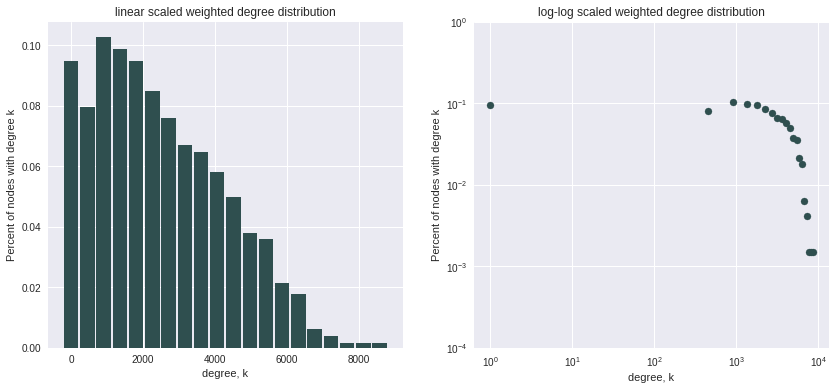

In [ ]:
degrees_weighted = sorted([w for (d, w) in G.degree(weight="weight")])

figs, axs = plt.subplots(1,2, figsize=(14,6))

n_bins = 20
count, bins = np.histogram(degrees_weighted, bins=n_bins)
xbins=bins[:len(bins)-1]
probs = count/sum(count)


axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_ylim(1e-4,1)

axs[0].bar(xbins, probs, 400, color="darkslategray")
axs[1].scatter(xbins, probs, color="darkslategray")

for i in range(2):
  axs[i].set_xlabel('degree, k')
  axs[i].set_ylabel('Percent of nodes with degree k')

axs[0].set_title("linear scaled weighted degree distribution")   
axs[1].set_title("log-log scaled weighted degree distribution")   

plt.show()

It appears in the plots that the weighted degree distribution is not very well described with a power-law distribution. In the linear scaled plot the percent of nodes with a certain degree seem to decrease linearly with the degree. Furthermore, the log-scaled plot shows that the degrees do not follow a straight line. Neither does the distribution seem to indicate that the network is a random network. In [2009, Diego Garlaschelli](https://arxiv.org/abs/0902.0897) research indicates that a weighted random network has a binomial distributed degree distribution, which does not seem to be the case for our network. 

As many "real" networks follow a power-law distribution, one might have expected this network to do as well. However, the observed distribution suggests that a large portion of users have higher degree (more common subreddits) than "expected" if they followed a power-law distribution. This could be a result of what we previous observed - that there might be some popular subreddits which many users subscribe to. This would increase the degree of many users due to links which are not formed based on some "informative" common subreddit between two users. Essentially, we hope to link certain "types" of users who uses specific subreddits. Therefore are links based on subreddits which all users tend to use not very interesting. This problem is further investigated in section **3.2.1**

Finally, the network is plotted using the ``ForceAtlas2`` module, with some chosen parameters.

In [ ]:
# Calculate position with the ForceAtlas2 algorithm
forceatlas2 = ForceAtlas2(outboundAttractionDistribution=True,  # Dissuade hubs
                          edgeWeightInfluence=1.0,
                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          # Tuning
                          scalingRatio=2.0,
                          strongGravityMode=False,
                          gravity=1.0,
                          # Log
                          verbose=True)

pos = forceatlas2.forceatlas2_networkx_layout(G=G, pos=None, iterations=2000)

100%|██████████| 2000/2000 [02:15<00:00, 14.72it/s]


BarnesHut Approximation  took  21.57  seconds
Repulsion forces  took  43.39  seconds
Gravitational forces  took  0.31  seconds
Attraction forces  took  66.18  seconds
AdjustSpeedAndApplyForces step  took  1.41  seconds


Now that positions are computed for each node, we color nodes according to their ``from_subreddit`` attribute and size them proportionally to their weighted degree

In [ ]:
# Make colors and node sizes for network
def node_size_and_colouring(network, color_trump, color_biden):
    color_map = []
    node_sizes = []


    for name in network.nodes:
        node_sizes.append((network.degree([name], weight="weight")[name]+1)/10)

        if network.nodes[name]['from_subreddit'] == 'trump':
            color_map.append(color_trump)
        elif network.nodes[name]['from_subreddit'] == 'biden':
            color_map.append(color_biden)
        else:
            print("Error")
    return color_map, node_sizes

color_map, node_sizes = node_size_and_colouring(G, "crimson", "royalblue")

And finally we plot the network, where we zoom in on the majority of nodes. Red nodes are found on https://www.reddit.com/r/donaldtrump/ and blue nodes on https://www.reddit.com/r/joebiden/

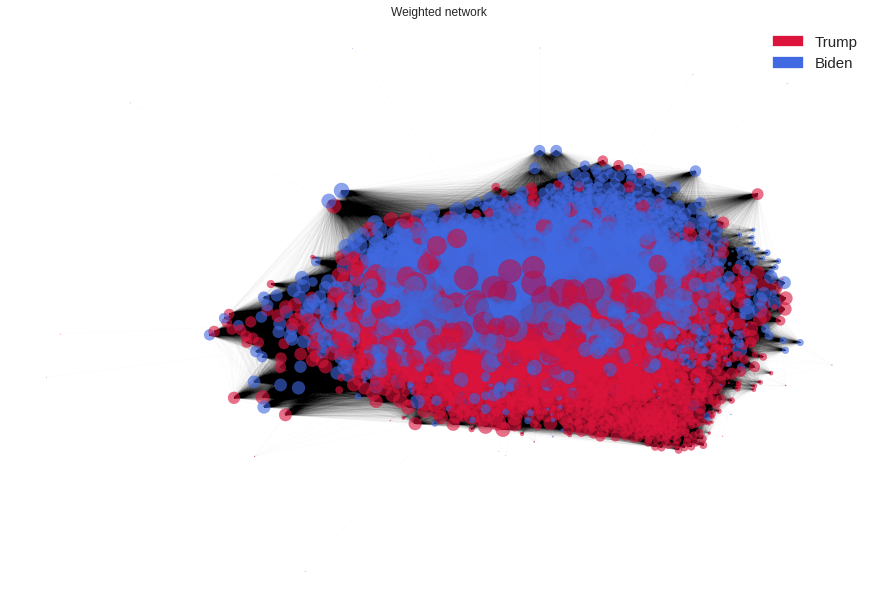

In [ ]:
fig = plt.figure(figsize=(12, 8))
# We plot twice to make edges more transparent than nodes. 
nx.drawing.nx_pylab.draw(G, pos=pos, node_color=color_map, node_size=node_sizes, with_labels=False, edge_color='white', alpha=.6)
nx.drawing.nx_pylab.draw(G, pos=pos, node_color=color_map, node_size=node_sizes, with_labels=False, edge_color='black', alpha=.01)
plt.title("Weighted network")
t_patch = mpatches.Patch(color="crimson", label="Trump")
b_patch = mpatches.Patch(color="royalblue", label="Biden")
plt.legend(handles=[t_patch, b_patch], loc="best", fontsize="15")
#plt.ylim((-0.3, 0.3))
#plt.xlim((-0.3, 0.3))
plt.show()

As previous mentioned, force directed layout algorithms produces plots where densely connected nodes generally are positioned closer to each other, and less connected nodes farther away. Thus, that the plot above roughly reveals two clouds of users mean that there is a tendency that users who comments on the trump subreddit typically comments on the same other subreddits, and vice versa with the Joe biden subreddit. In the paper which the``ForceAtlas2`` implementation is based on, it is mentioned that these kind of algorithms visualize community structures in accordance with the modularity measure ([2014, Mathieu Jacomy et al](https://journals.plos.org/plosone/article?id=10.1371/)). Whether there is an actual community structure is further examined in **section 3.2.2**

## 3.2 Extracting networks of interest and classifying users

### 3.2.1 Extracting the "backbone" of the user network


#### 3.2.1.1 Motive

We saw in section 3.1.1.1 that the weighted network was very dense. With such an overwhelming number of connections there will arguably be a lot of redundant information (Serrano 2009, 6483). 

Therefore it would be a good idea to attempt to reduce the complexity of the network while preserving the key features and information contained in the network. This can be seen as a network science analogy to performing principal component analysis on very high dimensional feature spaces known from machine learning. 

One immediate idea could be to preserve links having a certain weight and stripping links under this threshold from the network. However this kind of global thresholding would mean that we simply lose the information of the links with a weight under the somewhat arbitrary global threshold value (Serrano 2009, 6483).

A way to reduce the complexity in a more careful way is presented in the article Extracting the multiscale backbone of complex weighted networks (Serrano 2009). The core idea is to preserve the edges that are statistically significant for the network model in relation to a null hypothesis model where the weights are randomly uniform. A more detailed explanation will be provided in the following subsection. 





#### 3.2.1.2 Tools
We want to develop a so-called disparity filter to use as a tool for the complexity reduction. To develop this tool, the first thing needed is a way to let each node $i$ in the network assign a relative importance $p$ to its links:

$$
p_{ij} = \frac{w_{ij}}{\sum_j w_{ij}} \quad \text{for} \quad i \in I
$$

Thus for each link $j$ that a node has the formula above expresses the proportion of the nodes total weight that link $j$ carries. This allows us to express the level of local heterogenity or disparity in link weights (Serrano 2009, 6484). The next step is to consider what the disparity for a nodes weights should be expected to look like if the normalized weights $p_{ij}$ were placed uniformly random between 0 and 1. This means our null hypothesis is:

$$
\mathbf{H_0}: \text{For a node i with degree k,} \quad p_{ij} \sim U(0,1)
$$

Now we can take a certain node with degree $k$. Then we place $k-1$ points in the interval $[0,1]$ with uniform probability. 

The lengths of the resulting subintervals can be seen as the $p_{ij}$. They will represent the expected values of the $k$ normalized weights if they were randomly drawn from a uniform distribution (Serrano 2009, 6484).

The probability distribution function for one of the values $p_{ij}$ taking a specific value $x$ is given by:

$$
p(x)dx = (k-1)(1-x)^{k-2}dx  \quad \text{(Serrano 2009, eq. 1)}
$$

It can be seen that this probability is dependent on the degree of the node in question. For example, for a node with two links, $k=2$ it can be seen that $p(x)dx=1dx$, which means that the single point dividing the interval into two lengths has uniform probability in the interval. 

For each node $i$ with links $j \in J$ this means, if the null hypothesis, $\mathbf{H_0}$ is true, that the probability of observing a normalized weight with a value as extreme or more extreme than $p_{ij}$ can be calculated by:

$$
\alpha_{ij} = 1 - (k-1)\int_0^{p_{ij}}(1-x)^{k-2}dx \quad \text{(Serrano 2009, eq. 2)} 
$$

A certain $p$ or $\alpha$-value can then be set to form a criterion for when a link is significant. This means a link $j$ is significant if 

$$
\alpha_{ij} < \alpha
$$

Again to provide a simple example with node degree $k=2$, it can be seen that the calculation of $\alpha_{ij}$ simplifies to $\alpha_{ij} = 1 - p_{ij}$. When $p_{ij}$ is close to 1, then link $j$ carries a lot of the total weight of the links connecting to node $i$ and so it should be an important link for node $i$. This is reflected by $\alpha_{ij}$ which is consequently close to zero, meaning that it would be statistically significant to some level $\alpha$.   

The function `disparity_filter` below implements the calculation of $\alpha$-values for every link weight for every node in $G$ and rebuilds $G$ with an additional edge attribute containing the $\alpha$-value:

In [ ]:
def disparity_filter(G):
    """
    References:
    python-backbone-network, https://github.com/aekpalakorn/python-backbone-network
    M. A. Serrano et al. (2009) Extracting the Multiscale backbone of complex weighted networks. PNAS, 106:16, pp. 6483-6488.
    """
    Gdf = nx.Graph()
    for idx, i in enumerate(G):
        if (idx + 1) % 500 == 0:
            print(f"Node {idx+1} of {len(G)}")

        # Node degree
        k = len(G[i])

        # Save node with attribute
        Gdf.add_node(i, from_subreddit=G.nodes[i]["from_subreddit"])

        if k > 1: # (Serrano 2009, footnote, p. 6485)
            
            # Node strength:
            s_i = sum( G[i][j]["weight"] for j in G[i])
            
            for j in G[i]:

                # Disparity Filtering
                w_ij= G[i][j]["weight"]
                p_ij = w_ij / s_i 
                alpha_ij = 1 - (k-1) * scipy.integrate.quad(lambda x: (1-x)**(k-2), 0, p_ij)[0]

                # Save neighbor node with attribute
                Gdf.add_node(j, from_subreddit=G.nodes[j]["from_subreddit"])

                # Saving edge with alpha-value
                Gdf.add_edge(i, j, common_subreddits=G[i][j]["common_subreddits"], weight=w_ij, alpha=alpha_ij)

    return Gdf

With the $\alpha$-values in place the function `alpha_cut` rebuilds G with only significant nodes. Note that the `try`-`except` statement is due to the fact that the $\alpha$-values are only assigned for nodes with a degree larger than 1. 

This is in turn due to a slight technicality of the algorithm. If a node $i$ with degree $k_i = 1$ is connected to a node $j$ of degree $k_j > 1$, then the significance of the link is determined from the threshold on node $j$ (Serrano 2009, 6485, footnote *) which is implemented above as simply not performing a the $\alpha$-value calculation for nodes with degree 1, thus it is possible that a node does not have the `alpha`-attribute. If a node $i$ does not have the `alpha`-attribute, the value of the node $i$ alpha is set to 1, which means that the link will fail the significance test and its fate will then depend on the threshold of connected node $j$.

In [ ]:
def alpha_cut(G, alpha_level=0.05):
    """
    python-backbone-network, https://github.com/aekpalakorn/python-backbone-network
    M. A. Serrano et al. (2009) Extracting the Multiscale backbone of complex weighted networks. PNAS, 106:16, pp. 6483-6488.
    """
    D = nx.Graph()
    for u, v, attributes in G.edges.data(data=True):
        try:
            alpha = attributes["alpha"]
        except KeyError:
            alpha = 1
        
        if alpha < alpha_level:
            D.add_node(u, from_subreddit=G.nodes[u]["from_subreddit"])
            D.add_node(v, from_subreddit=G.nodes[v]["from_subreddit"])
            cs = attributes["common_subreddits"]
            w = attributes["weight"]
            D.add_edge(u,v, common_subreddits=cs, weight=w)
    return D

In [ ]:
path = "/content/G_weighted_T_B_removed.gpickle"
G = nx.read_gpickle(path)

Ntot = len(G.nodes)
Ltot = len(G.edges)
Wtot = sum([weight for u,v,weight in G.edges.data(data="weight")])


The authors argue that this method will work best if their is a heigh level of weight heterogeneity at both a global and local scale (Serrano 2009, 6487). On the global level this would mean that the weights present in the network takes a lot of different values. On the local level the following measure of heterogeneity can be applied on each node $i$:

$$
kY_i(k) = k \sum_j p_{ij}^2 \quad \text{(Serrano 2009, eq. 3)}
$$

In the equation above it can be seen that if the weights of a node are perfectly homogeneous, then all the normalized weights $p_{ij}$ are equal and $kY_i(k) = 1$. 

This indicates why the method will node work in a network thats too high a degree of homogeneity: It will be increasingly difficult to set a significance level that will be able to actually remove links. 

Conversely, in the case of perfect heterogeneity where only one $p_{ij} = 1$ meaning that this weight accounts for all the weight, then $kY_i(k) = k$. 

The function `local_heterogeneity` below implements equation 3:

In [ ]:
def local_heterogeneity(G):
    nodes_by_ascending_degree = sorted(G.degree, key=lambda x: x[1], reverse=False)
    upsilon = []
    degrees = []
    for tup in nodes_by_ascending_degree:
        i = tup[0]
        k = tup[1]
        degrees.append(k)

        # Calculate sum of weights of incident edges
        s_i = sum(G[i][j]["weight"] for j in G[i])

        # Calculate square on each normalized weight
        pij_sq = [ (G[i][j]["weight"] / s_i)**2 for j in G[i]]

        # Sum of the squares:
        sum_pij_sq = sum(pij_sq)

        # Upsilon(i, k)
        upsilon.append( k * sum_pij_sq )
    
    return upsilon, degrees

#### 3.2.1.3 Results and discussion

First we will asses both the global distribution of weights and the local level of heterogeneity in the following plots:

In [ ]:
weights = []
for u, v, weight in G.edges.data(data="weight"):
  weights.append(weight)

upsilon, degrees = local_heterogeneity(G)

In [ ]:
n_bins = 17
weight_counts, bins = np.histogram(weights, bins=n_bins)
xbins=bins[:len(bins)-1]
wprobs = weight_counts / sum(weight_counts)

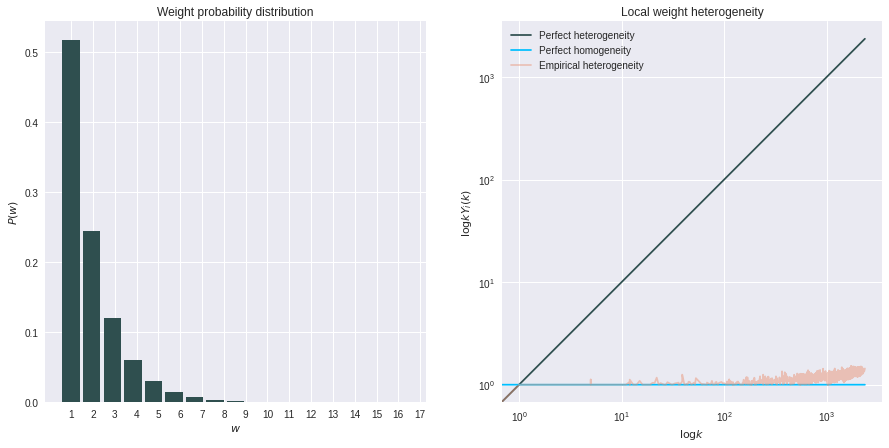

In [ ]:
plt.style.use("seaborn")
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
ax0.bar(xbins, wprobs, color="darkslategray")
ax0.set_xticks(list(set(weights)))
ax0.set_title("Weight probability distribution")
ax0.set_xlabel("$w$")
ax0.set_ylabel("$P(w)$")
ax1.plot(degrees, degrees, color="darkslategray")
ax1.plot(degrees, np.ones(len(degrees)), color="deepskyblue")
ax1.plot(degrees, upsilon, color="darksalmon", alpha=0.5)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_title("Local weight heterogeneity")
ax1.set_xlabel("$\log k$")
ax1.set_ylabel("$\log kY_i(k)$")
ax1.legend(["Perfect heterogeneity", "Perfect homogeneity", "Empirical heterogeneity"])
fig.show()

From the global weight probability distribution, it can se seen that almost the entire probability mass is placed for weights less than 6. This means that on a global level the weights are not very heterogeneous as most weights are small. 

From the plot of the local weight heterogeneity, it can be seen that the local heteregeneity is also relatively small. 
However it can be seen that the heterogeneity seems to increase for nodes that have a high degree. This means that we will be able to apply the method with some success if we use relatively small values of $\alpha$.

Also it will likely mean that the most removal of links will happen at nodes that have a high degree, because the heterogeneity is generally highest in these regions of the network. 

Next we will need to consider at which significance level we should perform the removal of links. To this end we can look at the fraction of preserved nodes $N_B / N_{TOT}$ as a function of the fraction of preserved links $L_B / L_{TOT}$ and as a function of the fraction of preserved weight $W_B / W_{TOT}$. 

First the network is filtered with the disparity filter, assigning an $\alpha$-value to all the links in $G$:

In [ ]:
Gdf = disparity_filter(G)

Node 500 of 2697
Node 1000 of 2697
Node 1500 of 2697
Node 2000 of 2697
Node 2500 of 2697


In the following `for`-loop we will perform a search through 50 $\alpha$-values in the range $[0.01, 0.5]$. In each iteration the function `alpha_cut` builds a new graph only containing links that are significant. 

In [ ]:
# Authors recommend alpha values in range [0.01, 0.5]
alpha_levels = np.arange(0.01, 0.51, 0.01)

xvals_edgefraction = []
xvals_weightfraction = []
yvals_nodefraction = []
for alpha_level in alpha_levels:
    B = alpha_cut(Gdf, alpha_level=alpha_level)

    # Nodes and links preserved
    Nb = len(B.nodes)
    Lb = len(B.edges)

    # Weight preserved
    Wb = sum([weight for u,v,weight in B.edges.data(data="weight")])

    xvals_edgefraction.append(Lb / Ltot)
    xvals_weightfraction.append(Wb / Wtot)
    yvals_nodefraction.append(Nb / Ntot)

The lists holding the values will be plotted shortly. Before that we define the function `global_threshold` which implements the immediate approach mentioned above. The function `global_threshold` creates a new graph from $G$ that only contains the nodes connected by links carrying weights over a given global threshold value. 

In [ ]:
def global_threshold(G, threshold):
    GT = nx.Graph()
    for u,v,weight in G.edges.data(data="weight"):
        if weight >= threshold:
            GT.add_edge(u,v, weight=weight)
    return GT

Above we increased the $\alpha$-values gradually decreasing the level of statistical significance and consequently allowing more links to stay in the network. For the global threshold we instead decrease the global threshold from the maximum weight 17 in the network to a threshold of 1 which means that we gradually allow more links: 

In [ ]:
max_weight = max([weight for u,v,weight in G.edges.data(data="weight")])
xvals_GT_edgefraction = []
xvals_GT_weightfraction = []
yvals_GT_nodefraction = []

for threshold in np.linspace(max_weight, 1, 50):
    GT = global_threshold(G, threshold=threshold)

    # Nodes and links preserved
    Ngt = len(GT.nodes)
    Lgt = len(GT.edges)

    # Weight preserved
    Wgt = sum([weight for u,v,weight in GT.edges.data(data="weight")])

    xvals_GT_edgefraction.append(Lgt / Ltot)
    xvals_GT_weightfraction.append(Wgt / Wtot)
    yvals_GT_nodefraction.append(Ngt / Ntot)

Now everything is in place to create the plots:

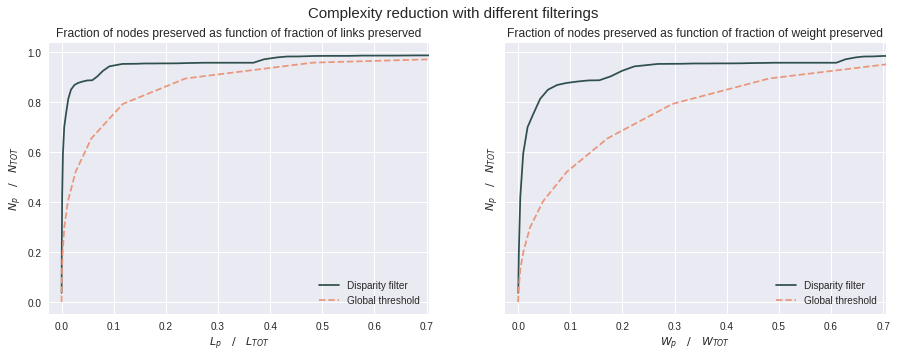

In [ ]:
plt.style.use("seaborn")
ys = [yvals_nodefraction, yvals_GT_nodefraction]
xs = [xvals_edgefraction,xvals_weightfraction, xvals_GT_edgefraction, xvals_GT_weightfraction]

meth_0 = "Disparity filter"
meth_1 = "Global threshold"
desc_0 = "Fraction of nodes preserved as function of fraction of links preserved"
desc_1 = "Fraction of nodes preserved as function of fraction of weight preserved"
ylabel = "$N_p \quad / \quad N_{TOT}$"
xlabels = ["$L_p \quad / \quad L_{TOT}$", "$W_p \quad / \quad W_{TOT}$"]
m = [meth_0, meth_1]
d = [desc_0, desc_1]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharey=True)

for idx, ax in enumerate(axes):
  ax.plot(xs[idx], ys[0],color="darkslategray", label=meth_0)
  ax.plot(xs[idx+2], ys[1], "--", color="darksalmon", label=meth_1)
  ax.set_xlim(-0.025, max(xs[0]))
  ax.set_title(d[idx])
  ax.set_ylabel(ylabel)
  ax.set_xlabel(xlabels[idx])
  ax.legend()

fig.suptitle("Complexity reduction with different filterings", fontsize=15)
fig.show()

From the plots it can be seen that we are able to greatly decrease the number of links and consequently a large amount of weight while keeping a lot of the nodes. Also it can be seen that the disparity filter is able to preserve a higher fraction of nodes with lower fractions of links and weights. This means that it is a worthwhile choice to use the disparity filter instead of the simple global thresholding filter as we clearly keep more information with fewer links. 

From dimensionality reduction techniques such as principal component analysis it is customary to look at so-called scree plots to decide on a number of features that to some extent explains most of the variance in a data set. This would mean to select the number of features that gives rise to the steepest slopes in the fraction of variance explained by including them as most information is held in these features.  

If we follow this intuition and apply it to the present case of network analysis, it seems like a good choice to select an $\alpha$-values that gives us the most nodes for the cost of least links as this will preserve the most information and the least redundant links.

Upon visual inspection of the plots it seems that an $\alpha$-value of around 0.09 will preserve around 85 \% of the nodes will retaining only around 2.5 \% of the links. Therefore we choose $\alpha = 0.09$ to perform the $\alpha$-cut on $G$, hence creating our backbone network $B$:

In [ ]:
B = alpha_cut(Gdf, alpha_level=0.09)
print("Fraction of nodes preserved:", len(B.nodes)/Ntot)
print("Fraction of links preserved:", len(B.edges)/Ltot)

Fraction of nodes preserved: 0.8694846125324435
Fraction of links preserved: 0.024555047570639494


The basic statistics of the resulting weighted network $B$ is presented below in comparison with the original weighted network $G$ which was first presented in section 3.1.3.3. 

In [ ]:
CCs = list(nx.connected_components(G))
nodes_of_LC = (max(CCs, key=len))
G = G.subgraph(nodes_of_LC).copy()

Bdegw = [d for user, d in B.degree(weight="weight")]
Gdegw = [d for user, d in G.degree(weight="weight")]

def avg_weight(network):
  return round(np.mean([w for u, v, w in network.edges(data="weight")]), 2)


df_stats = pd.DataFrame({'N':[len(G.nodes), len(B.nodes)],
                         'L':[len(G.edges), len(B.edges)],
                         'Min degree':[np.min(Gdegw), np.min(Bdegw)],
                         'Max degree':[np.max(Gdegw), np.max(Bdegw)],
                         'Median degree':[int(np.median(Gdegw)), int(np.median(Bdegw))],
                         'Mode':[Counter(Gdegw).most_common(1)[0][0], Counter(Bdegw).most_common(1)[0][0]],
                         'Avg weight':[avg_weight(G),avg_weight(B)],
                         '⟨k⟩':[int(round(np.mean(Gdegw), 0)), int(round(np.mean(Bdegw),0))]
                         }, index=["G", "B"])

df_stats

,N,L,Min degree,Max degree,Median degree,Mode,Avg weight,⟨k⟩
G,2669,1849355,1,9022,2393,1022,1.94,2690
B,2345,45411,3,4592,107,3,5.91,229


The most notable change is the reduction by a factor of 40 of the links in the network. Along with this change there are several other things to notice in the table above:

1.   The minimum degree has shifted to a value of 3 which means that the user with least interests in common with other user's now has three such interests.


2.   There has been a shift in the other direction for the maximum degree where it can be seen that the maximum degree is approximately halved. This is likely because many of the links which was removed was highly popular subreddits which linked many, many users with a superficial, low weight and accordingly a lot of these connections is lost for the most connected node. 

3. The reasoning from point 2 is probably also the reason why the average weighted degree has gone from 2690 to 229. 

These effects is considered positive as the network can now be seen as more focused with regards to spotting interest communities in the network. 

In this way, point 1 this can be seen as a "lower bound" for how weak or shallow connections between users we now consider. Meanwhile point 2 and 3 can be interpreted as removing a lot of noise from the very connected nodes and the remaining nodes in general. Noise in this respect will be that some subreddits like general advice subreddits and news subreddits are very common interests, so by their exclusion by the filtering we don't lose too much information.  

Also:

4. We see that the average weight of the remaining links has increased, meaning that the reduction in links must have happened mainly on links with relatively low weights in the network. 

As this is the first indication that confirms the assumptions in the reasoning of this section, we want to back it up by exploring which links were removed. Consider the following bar plots, where the distributions of respectively the weights removed the weights that were kept by `alpha_cut` are shown:




In [ ]:
def about_alpha_cut(G, alpha_level=0.05):
    cut_weight = []
    cut_reddit = []
    cut_red_append = []

    stay_weight = []
    stay_reddit = []
    for idx, (u, v, attributes) in enumerate(G.edges.data(data=True)):
        try:
            alpha = attributes["alpha"]
        except KeyError:
            alpha = 1
        if alpha < alpha_level:
            stay_weight.append(attributes["weight"])
            stay_reddit += attributes["common_subreddits"]
        elif alpha >= alpha_level:
            cut_weight.append(attributes["weight"])
            cut_reddit += attributes["common_subreddits"]
            cut_red_append.append(attributes["common_subreddits"])

    return cut_weight, cut_reddit, cut_red_append, stay_weight, stay_reddit

cw, cr, cra, sw, sr = about_alpha_cut(Gdf, alpha_level=0.09)

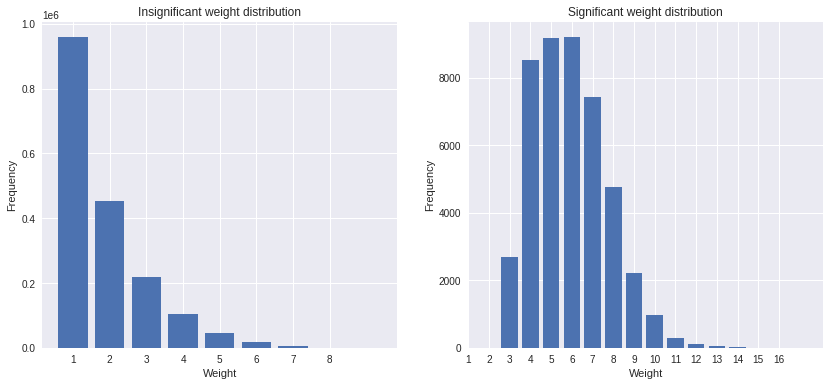

In [ ]:
def discrete_bar(weight_list):
  counter = Counter(weight_list)
  bins = [k for k in counter.keys()]
  counts = [v for v in counter.values()]
  return [bins, counts] 

bc = [discrete_bar(cw), discrete_bar(sw)]
titles = ["Insignificant weight distribution", "Significant weight distribution"]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
for idx, ax in enumerate(ax):
  ax.bar(bc[idx][0], bc[idx][1])
  ax.set_title(titles[idx])
  ax.set_ylabel("Frequency")
  ax.set_xlabel("Weight")
  ax.set_xticks([x for x in range(1, max(bc[idx][0]))])


We see that almost a million of the insignificant links that were removed was links with a weight of 1. Also it can be see that the significant weights looks almost Poisson distributed around the mean of $\approx 6$ and it can be noticed that there are simply no weights less than 3 among the significant weights. 

In the code-block below we will consider which subreddits appeared most commonly in respectively insignificant and significant links:

In [ ]:
counter_cr = Counter(cr)
counter_sr = Counter(sr)
print("Most common subreddits at insignificant links: ")
print(counter_cr.most_common(10))
print("\n Most common subreddits at significant links: ")
print(counter_sr.most_common(10))

Most common subreddits at insignificant links: 
[('Ask Reddit...', 523921), ('Politics', 507271), ('All news, US and international.', 210530), ('Reddit Pics', 171405), ('World News', 162303), ('Conservative', 145589), ('funny', 118307), ('Today I Learned (TIL)', 97162), ('/r/PublicFreakout', 89264), ('A subreddit for cute and cuddly pictures', 55940)]

 Most common subreddits at significant links: 
[('Ask Reddit...', 22614), ('Politics', 15482), ('Reddit Pics', 14950), ('All news, US and international.', 14255), ('World News', 12633), ('funny', 11488), ('Today I Learned (TIL)', 10718), ('/r/PublicFreakout', 7316), ('.gifs - funny, animated gifs for your viewing pleasure', 5573), ('/r/videos', 5147)]


It can clearly bee seen that the most common subreddits at insignificant links are very general and broadly appealing subreddits like "Ask Reddit", "Polictics" and "World News" as we expected a few text blocks above. 

There is however also the subreddit "Conservative" which name indicates that it may not be for everyone. Since an overwhelming amount of the removed links had weight 1, there is a fair probability that the links holding this subreddit connected Trump-minded people on a superficial level. However, had we discovered a bond between Trump-supporters and American conservatism this may not have been too informative regardless. 

Meanwhile it can be seen that this is also the case for the significant links and the two lists are almost identical. This will be considered to be a positive observation as the network can be seen to have preserved a distinctive quality after the disparity filtering, namely that the popular subreddits should be popular.

In [ ]:
def subreddit_cut_with_weight(cutweights, cutreddits, pattern, weights):
    count = 0
    for idx, w in enumerate(cutweights):
        if w in weights:
            for elem in cutreddits[idx]:
                if pattern in elem:
                    count += 1

    return count

ar = subreddit_cut_with_weight(cw, cra, "Ask Reddit", [1])
an = subreddit_cut_with_weight(cw,cra, "All news, US and international.", [1])
cn = subreddit_cut_with_weight(cw, cra, "Politics", [1])

print(f"r/Ask Reddit   removed in links with weight 1: {ar}")
print(f"r/All news, US and international removed in links with weight 1: {an}")
print(f"r/Politics removed in links with weight 1: {cn} \n")
print(f"Fraction of removals accounted for: {(ar+an+cn)/(len(G.edges)-len(B.edges))}")

r/Ask Reddit   removed in links with weight 1: 185013
r/All news, US and international removed in links with weight 1: 38235
r/Politics removed in links with weight 1: 220803 

Fraction of removals accounted for: 0.24615564562979783


The code block above counts the number of times certain very general subreddits has been removed as a shallow connection of weight 1 and these removals can be seen to account for about 25 \% of the total links removals. Thus this also seems to support what we expected from looking at the basic statistics of the filtered network. 

Next we can consider the resulting weighted degree distribution for $B$. It turns out that it is a whole other picture than what we observed in section 3.1.4.3:

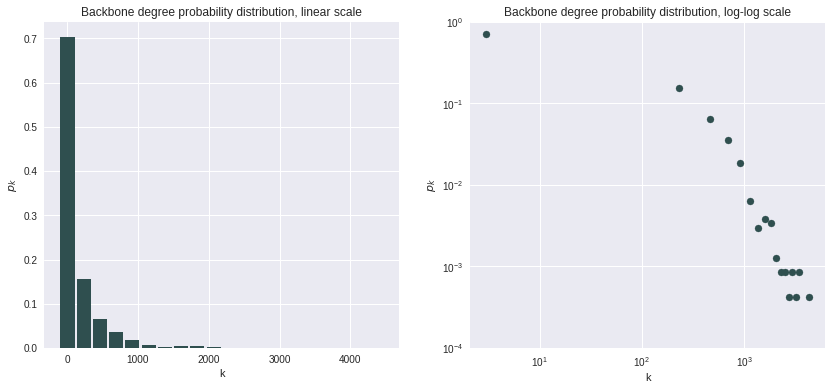

In [ ]:
n_bins = 20
count, bins = np.histogram(Bdegw, bins=n_bins)
xbins=bins[:len(bins)-1]
probs = count/sum(count)

fig, ax = plt.subplots(1,2, figsize=(14,6))
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_ylim(1e-4,1)
ax[0].bar(xbins, probs, 200, color="darkslategray")
ax[1].scatter(xbins, probs, color="darkslategray")
ax[0].set_title("Backbone degree probability distribution, linear scale")
ax[1].set_title("Backbone degree probability distribution, log-log scale")

for a in ax:
  a.set_xlabel("k")
  a.set_ylabel(r"$p_k$")

fig.show()

From the degree distribution on both the linear and the log-log-scale it seems that the resulting weighted degree distribution appears to look like a scale-free network which can be seen as the distributions appears to follow a power-law distribution. 

On the linear scale it is seen clearly that the vast majority of nodes have a low weighted degree and there are some heavily connected hubs. From the log-log-plot a power-law distribution and consequently a scale-free degree distrubution will appear as a straight line (Barabasi, 4.2) which to some extend seems to be the case here.  

Using the Python library `powerlaw` we can find the best power-law fit to our degree distribution and report the degree exponent $\gamma$:

In [ ]:
fit = powerlaw.Fit(Bdegw)

In [ ]:
gamma = fit.alpha
print(f"Degree exponent: {gamma} \n")

Degree exponent: 3.22228659621171 



The degree exponent $\gamma$ is found to be $\gamma \approx 3.2$. This places the degree distribution just over the critical point for being in a scale-free regime and it would be practically impossible to distinguish the properties of our network from the properties of a random network. This means that we cannot document that our network in fact has a scale-free nature (Barabasi, 4.7). 

To conclude this section we will now illustrate network $B$ with the ForceAtlas2 algorithm:

In [ ]:
# Calculate position with the ForceAtlas2 algorithm
forceatlas2 = ForceAtlas2(outboundAttractionDistribution=True, # Dissuade hubs
  edgeWeightInfluence=1.0,
  # Performance
  jitterTolerance=1.0, # Tolerance
  barnesHutOptimize=True,
  barnesHutTheta=1.2,
  # Tuning
  scalingRatio=2.0,
  strongGravityMode=False,
  gravity=1.0,
  # Log
  verbose=True)
pos = forceatlas2.forceatlas2_networkx_layout(G=B, pos=None, iterations=2000)

100%|██████████| 2000/2000 [01:27<00:00, 22.82it/s]

BarnesHut Approximation  took  23.22  seconds
Repulsion forces  took  58.98  seconds
Gravitational forces  took  0.29  seconds
Attraction forces  took  1.85  seconds
AdjustSpeedAndApplyForces step  took  1.13  seconds


In [ ]:
# Make colors and node sizes for network
def node_size_and_colouring(network, color_trump, color_biden):
  color_map = []
  node_sizes = []
  for name in network.nodes:
    node_sizes.append((network.degree([name], weight="weight")[name]+1)/5)
    if network.nodes[name]['from_subreddit'] == 'trump':
      color_map.append(color_trump)
    elif network.nodes[name]['from_subreddit'] == 'biden':
      color_map.append(color_biden)
    else:
      print("Error")
  return color_map, node_sizes

color_map, node_sizes = node_size_and_colouring(B, "crimson", "royalblue")

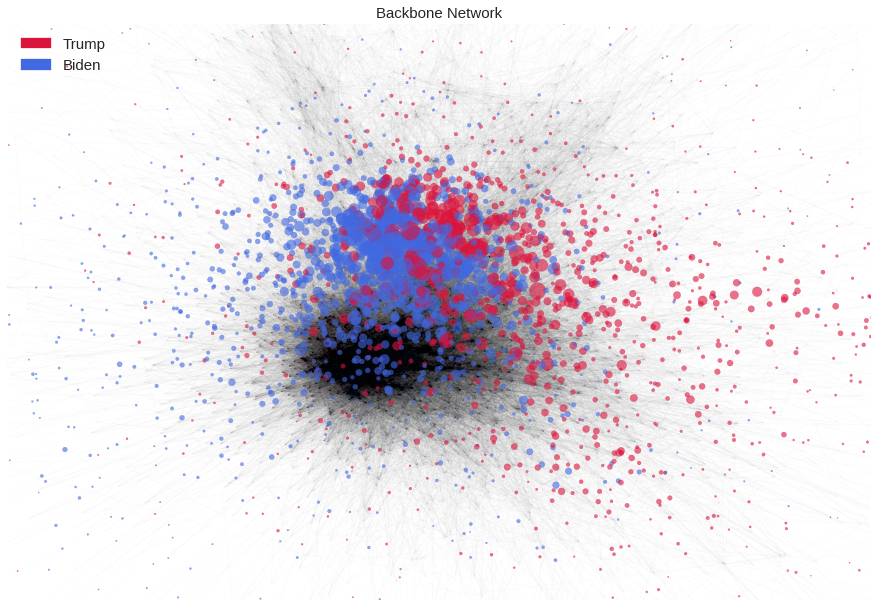

In [ ]:
fig = plt.figure(figsize=(12, 8))
nx.drawing.nx_pylab.draw(B, node_color=color_map, node_size=node_sizes, with_labels=False, edge_color="white", alpha=.6)
nx.drawing.nx_pylab.draw(B, node_color=color_map, node_size=node_sizes, with_labels=False, edge_color="black", alpha=.01)
plt.title("Backbone Network", fontsize=15)
t_patch = mpatches.Patch(color="crimson", label="Trump")
b_patch = mpatches.Patch(color="royalblue", label="Biden")
plt.legend(handles=[t_patch, b_patch], loc="best", fontsize=15)
plt.ylim((-0.05, 0.05))
plt.xlim((-0.05, 0.05))
plt.show()

From the network illustration it can be seen that there seem to be a tendency that the the blue Biden nodes cluster to the left in the plot while the red Trump nodes cluster to the right in the plot. This suggests that we should be able to make some differentiating among the users when considering this way of classifying our users. 

### 3.2.2 Classifying users with community Detection and sentiment analysis

#### 3.2.2.1 Motive

This section is about how to approach the network in terms of partitioning. The immediate intention of this project was to investigate differences and simmiliarities across cadidate supporters on reddit. However this approach presumes that users posting comments on a candidate subreddit do in fact support the cadidate. This might be an naiv assumption and could lead to faulty conlclusions. Instead different partionings of the graph is investigated, to detect significant structures within the network and check whether these partionings corralates with the users from_subreddit attribute. The aim is to reviel the validity of partioning the network in two groups of candidate supporters and whether to talk about *supporters* as such is a misleading in this context or not.



#### 3.2.2.2 Tools

**Modularity scores to detect community structures**

To validate the different partitionings of the network modularity is used. Modularity is a score that ranges from $[-\frac{1}{2}\  ; 1]$ and compares the wiring within communities with wiring across communities. The higher score the higher desity within communities and lower wiring across the partitioned communities. Modularity for a partioning of $n_c$ communities is calculated by:


$$M_{c}=\sum_{c=1}^{n_c}\left[ \frac{L_c}{L}- \left( \frac{k_c}{2L} \right) ^2 \right]$$

\\
With $L_c$ being links within the community $C_c$ and $k_c$ being the total degree the nodes in the community.

In a paper on community detection$^{[1]}$ it is stated that a modularity differing from 0 indicates a deviation from randomness, but that a score on above 0.3 is required before a significant community structure can be found in the network.

*$[1]$: Fast algorithm for detecting community structure in networks. M. E. J. Newman*




**Louvain for optimal partitioning**

Louvain algorithm is used to identify "the best" community partitioning in the graph. The algorithm belongs to the class of modularity maximization algorithms for community detection. Thus our search for community structure is following hypothesis H4 (Barabasi, section 9.4), namely that the partition of maximal modularity corresponds to the optimal community structure. 

According to the paper (Blondel et. alia 2008) (https://arxiv.org/abs/0803.0476) the algorithm works in two phases that repeats iteratively:

***Phase one***: Each node $i$ in a network of $N$ nodes is divided into a community for each node. Then for each neighbor $j$ of $i$, the algorithm calculates the gain in modularity $\Delta Q$ that would be achived by placing $i$ in $j$'s community $C$. This gain is calculated by 

$$
\Delta Q = \big[ \frac{\sum_{in}+k_{i,in}}{2m} - (\frac{\sum_{tot}+k_{i}}{2m})^2 \big] - \big[ \frac{\sum_{in}}{2m} - (\frac{\sum_{tot}}{2m})^2 - (\frac{k_i}{2m})^2  \big], 
$$

where $\sum_{in}$ is the sum of the weights of the links inside $C$, $\sum_{tot}$ is the sum of the weights of the links incident to nodes (i.e. links that share a node) in $C$, $k_i$ is the sum of the weights of the links incident to node $i$, $k_{i,in}$ is the sum of the weights of the links from $i$ to nodes in $C$ and finally $m$ is the sum of the weights of all the links in the network. If there is no positive gain in modularity, $i$ stays in its community. This goes on in to there are no more movements of nodes to communites that would yield a positive gain in modularity.

***Phase two***:
The second phase consists in building a new network where the nodes are the communities found in phase one. The weights of the links between the nodes (former communities) in the new network are given by summing up the weights of the links between nodes in the two former communities. After the new network has been created phase one can be reapplied. The algorithm terminates when there are no more positive gain achieved to the modularity of the network. **(ref assignment 2)**

**Subreddit Frequency**

Looking at the frequency of commented subreddits for users within communities will give an insight of how the communities have been partioned and reveal characteristics of the communities. 

**Sentiment analysis for alternative classification** 

Lastly community partitioning through setiment analysis is investigated. With the notion of from_subreddit being a more neutral attribute and the sentiment of each comment being the crucial indicator. To store sentiment for every comment, data on the sentiment of words is required. For this purpose, the LabMT wordlist is used (from https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752). This data contains a long list of words with a corresponding happiness score (happiness_average below). This sentiment score is computed as the average evaluation from 1-10 of 50 users on the webplatform Mechanical Turk. **(ref assignment 2)**

The partitioning of users based on sintiment analysis is done in the following way:

- Catagorizing users with ***positive comments***, containing a candidate name, as supporters of the ***same candidate***. 

- Catagorizing users with ***negative comments***, containing a candidate name, as supporters of the ***opposite candidate***. 

- Categorizing users with comments containing both or no candate names as ***either*** supporters of same ***or*** opposite candidate depending on origin of subreddit and and sentiment of comment (same as origin if positive and opposite of origin if negative)


#### 3.2.2.3 Results and discussion

By looking at the Modularity score for a partitioning of users based on subreddit, an estimate of seperation is found on reddit activity for the two groups.

In [ ]:
# Method to partition based on the 'from_subreddit' attribute
def node_to_partition(graph, partitions):
  ntp = {}
  for idx, partition in enumerate(partitions):
    nodes_in_partition = [node for node, data in graph.nodes(data=True) if data.get("from_subreddit")==partition]
    for node in nodes_in_partition:
      ntp[node] = idx
  return ntp

# partion G into trump and biden partitions
G_ntp = node_to_partition(G, ["trump", "biden"])

# Calculate modularity for the entire network on the trump/biden partitioning in G
G_modularity = community.modularity(G_ntp, G)

print(f"\n\nModularity for trump and biden partitioning on G: {G_modularity} \n")



Modularity for trump and biden partitioning on G: 0.09175437865283112 



This partinioning seems to deviate from randomness, but 0.9 is still too low to categorize this partitioning in subreddit commented as significant.

This finding does not imply that there are no community structures what so ever. With the use of the Louvain algorithm a more optimal partitioning can be found in the network, to locate community structures regardless commented subreddet - revieling shared interests for both groups.

In [ ]:
# Louvain used for community detection in G
G_partition = community.best_partition(G, random_state=0)

# Extract size of each community found by Louvain
def get_community_sizes(partition_dict):
  D = partition_dict
  communities = set(D.values())
  community_sizes = []
  for k in range(len(communities)):
    size = sum(map((k).__eq__, D.values()))
    community_sizes.append(size)
  return community_sizes

G_community_size = get_community_sizes(G_partition)

print(f"Number of communities found: {len(G_community_size)}")

Number of communities found: 6


To better understand the partioning the communities are plotted in a bar plot with colours corresponding to the users from_subreddet attribute.

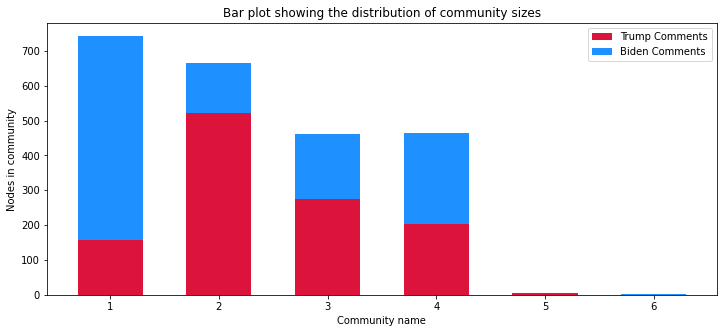

Sizes of communities: [743, 665, 461, 465, 4, 3]

Percentages for each community: 
 Trump comments: [0.21 0.78 0.59 0.43 1.   0.  ]
 Biden comments: [0.79 0.22 0.41 0.57 0.   1.  ]

Modularity for Louvain partitoning: 0.3169470769008109


In [ ]:
# Calculate numbers of trump subreddit comments in a community 
def candidateComments(community, G, partition, candidate):
  count = 0
  for node in G.nodes:
    if G.nodes[node]['from_subreddit'] == candidate and partition[node] == community:
      count = count + 1
  return count

# Make barplot collored according to candidate subreddit
def plotBarplot(trumps, bidens):
  index = np.arange(len(trumps))
  width = 0.6
  ticks = ('1', '2', '3', '4', '5', '6')

  # Generate Bar plots
  plt.figure(figsize=(12,5))
  p1 = plt.bar(index, trumps, width, color ='crimson')
  p2 = plt.bar(index, bidens, width, color ='dodgerblue', bottom=trumps)

  # Plot
  plt.title("Bar plot showing the distribution of community sizes")
  plt.xlabel("Community name")
  plt.ylabel("Nodes in community")
  plt.xticks(index, ticks[:len(trumps)])                                                           
  plt.legend((p1[0], p2[0]), ('Trump Comments','Biden Comments'))
  plt.show()


# Calculate numbers of candidate specific comments in each community 
G_trump_comments = np.array([candidateComments(i, G, G_partition, 'trump') for i in np.arange(len(G_community_size))])
G_biden_comments = np.array([candidateComments(i, G, G_partition, 'biden') for i in np.arange(len(G_community_size))])

plotBarplot(G_trump_comments, G_biden_comments)

print(f"Sizes of communities: {G_community_size}\n")
print(f"Percentages for each community: \n Trump comments: {np.round(G_trump_comments/G_community_size, 2)}\n Biden comments: {np.round(G_biden_comments/G_community_size,2)}" )
print(f"\nModularity for Louvain partitoning: {community.modularity(G_partition, G)}")

From this plot it seems that users in some of the communities found correlates with the commented candidate subreddit (community 1,2,5,6). Furthermore the modularity score is above the threshold 0.3, meaning this partioning has a significant structure within the network. Looking into the frequency of subreddits commented in each community, the theory of candidate specific communities can be investigated.

In [ ]:
# Method to users in a community
def extractUsersFromCommunity(community):
  community_1 = []
  for user in df['user']:
    try:
      if G_partition[user] is community:
        community_1.append(user)
    except:
      continue
  return community_1

# Method to exstract commented subreddits for each user in a community
def extractRedditsFromCommunity(community):
  subreddits = []
  reddit_counter = {}
  df_com = df.loc[df['user'].isin(community)].iloc[:, 2:4].copy()
  
  for subred in df_com['used_subreddits']:
    com1 = set(json.loads(subred))
    subreddits+=list(com1)
  
  community_TF_raw = nltk.FreqDist(subreddits)  #return popular_reddits, reddit_counter
  return community_TF_raw

# Put is all together and create a list frequency of 20 most commented subreddits for a community 
def redditFrequency(community_index):
  com = extractRedditsFromCommunity(extractUsersFromCommunity(community_index))
  com_list = [(v, k) for (v,k) in com.items() if v not in ["biden", "trump"]]
  sorted_RF = (sorted(com_list, key=lambda x: x[1], reverse=True)[:20])
  return sorted_RF

  # Create a Data Frame showing the frequency lists found for every community 
reddit_freqs = list(zip(redditFrequency(0),redditFrequency(1),redditFrequency(2),redditFrequency(3),redditFrequency(4),redditFrequency(5))) 
df_lol = pd.DataFrame(reddit_freqs, columns = ['Community 1','Community 2','Community 3','Community 4','Community 5','Community 6'])
df_lol



,Community 1,Community 2,Community 3,Community 4,Community 5,Community 6
0,"(Politics, 566)","(Conservative, 281)","(Ask Reddit..., 226)","(Ask Reddit..., 337)","(Conservative, 3)","(Breaking Mom - chocolate & whine, 3)"
1,"(All news, US and international., 302)","(Ask Reddit..., 199)","(/r/PublicFreakout, 156)","(Reddit Pics, 284)",(/r/XboxOne - The home of everything Xbox One ...,(Reddit Parenting - For those with kids of any...
2,"(World News, 268)","(/r/Memes the original since 2008, 189)","(funny, 143)","(Today I Learned (TIL), 234)","(r/gaming, 2)","(BabyBumps Graduates, 2)"
3,"(Ask Reddit..., 256)","(dankmemes, 144)","(Interesting As Fuck, 123)","(funny, 231)","(WoW: Classic, 2)","(Eating healthy on a cheap budget, 2)"
4,"(/r/PublicFreakout, 174)","(For your Opinions that are Unpopular , 106)","(Conservative, 121)","(All news, US and international., 225)","(World of Warcraft, 2)","(Relationships, 2)"
5,"(Novel Coronavirus (COVID-19), 169)","(Tucker Carlson: The Sworn Enemy of Lying, Pom...","(Reddit Pics, 119)","(Politics, 197)","(Dark Souls 2, 2)","(Aldi, 1)"
6,(2020 Political Hindsight - a Donald Trump lov...,"(Political Compass Memes, 90)","(A subreddit for cute and cuddly pictures, 110)","(World News, 193)","(/r/Bloodborne, 2)","(Female Fashion Advice, 1)"
7,"(Reddit Pics, 142)","(Politics, 84)","(All things Trashy!, 108)","(/r/videos, 173)","(NFL: National Football League Discussion, 2)","(shittyfoodporn, 1)"
8,"(White People Twitter, 125)","(r/teenagers, 82)","(Politics, 99)","(Movie News and Discussion, 153)","(Dark Souls 3, 2)","(Delaware, 1)"
9,"(Today I Learned (TIL), 121)","(A sub for Historymemes, 82)","(What Could Possibly Go Wrong?, 98)","(r/gaming, 150)","(PlayStation, 2)","(UNHhhh, 1)"


Investigating the top 20 most commented subreddits within each community leeds to some interesting findings espacially when comparing community 1 and 2 that have a majority of users commenting respectivly the biden and trump subreddit:

- Community 1 seems to have a bigger interest for World news and than Comminty 2. 

- Community 1 has a Corona subreddit at 5th place, whereas in community 2 no covid subreddit is found in top 20.

- The "Conservative" subreddit is the top commented subreddit in Community 2 and is nowhere to be found in Community 1.

- Community 2 has "conspiracy" in 10th place unlike no other community

These are all things that could contribute to the thought of Community 1 and 2 being seperated based on political beliefs. The other communities seem to have more neutral characteristics like humorous (Community 3), exploratory (Community 4), gaming (Community 5) and moms (Community 6). A funny thing to notice, despite the small numbers, is the strict seperation of community 5 and 6 in terms of candidate subreddit commented whereas users in community 3 and 4 is more evenly divided. 

Another thing to notice is the amount of subreddits appearing in different communities and their similiarities in numbers (e.g. 'Ask redit'). In a likely scenario were these subreddits are randomly distributed among users in the network this will work as a moderator for the modularity score, pushing it towards zero, since the edges contribution to the score is relative to the number of edges. Removing these "noisy" and more neutral subreddits would thereby increase the significants of the community structure for a given partitioning.

##### Sentiment classification

Lastly a partioning is carried out by looking at the sentiment score of each comment. The categorization is made using the criterias explained in tools. using 5 as value turning point whether to classify comments as positive (sentiment score above 5) or negeative (sentiment score below 5).

In [ ]:
# Load labMT
LabMT = pd.read_csv("drive/MyDrive/SGAI/labmt-sentiment-data.txt", sep="\t")

# Set for fast look-ups
LabMT_words_sentiment = set(LabMT['word'].values)

# Dict for quickly accessing score
LabMT_hap_avg = {}
words = LabMT['word'].values
scores = LabMT['happiness_average'].values

for w,s in zip(words, scores):
    LabMT_hap_avg[w] = s 

# Method for retrieving average sentiment score on a list of tokens
def calc_sentiment_of_tokens(tokens, hap_avg, words):
    sentiment_of_text = 0
    n_avg = 0

    # Create the frequency distribution and loop through it
    fdist = nltk.FreqDist(tokens)
    for w, f in fdist.items():
        # Check if the token is a part of the LabMT list
        if w in words:
            # Compute the weighted sentiment of this token (according to how many times the word occurs)
            sentiment_of_text += hap_avg[w]*f
            # Only compute the average with respect to the words which are in the LabMT list
            n_avg+=1*f

    # return error (-1) if none of the words in 'tokens' exist in the LabMT list
    return sentiment_of_text/n_avg if n_avg>0 else -1

# Method to make partioning based on usernames
def users_to_partition(G,trump,biden):
  ntp = {}
  for node, data in G.nodes(data=True):
    if any(node in s for s in trump):
      ntp[node] = 0
    if any(node in s for s in biden):
      ntp[node] = 1
  return ntp

In [ ]:
# Categorizing users based on sentiment and mentioned candidate/from_subreddit attribute
biden = []; trump = []
count1 = 0; count2 = 0; count3 = 0; count4 = 0
avg_sentiment = 0
sentiment_threshold = 5
for i in np.arange(len(df)):
  comment_raw = re.findall(r"\w+(?:[-']*\w*)*", df['comment'][i])
  comment = [w.lower() for w in comment_raw]
  sentiment = calc_sentiment_of_tokens(comment, LabMT_hap_avg, words)
  avg_sentiment += sentiment

  # If both candidate mentioned
  if any("trump" in s for s in comment) and any("biden" in s for s in comment):
    count1 += 1 
    if df['from_subreddit'][i] == 'trump':
      if sentiment > sentiment_threshold:
        trump.append(df['user'][i])
      else:
        biden.append(df['user'][i])
    if df['from_subreddit'][i] == 'biden':
      if sentiment > sentiment_threshold:
        biden.append(df['user'][i])
      else:
        trump.append(df['user'][i])

  # If Trump mentioned
  elif any("trump" in s for s in comment):
    count2 += 1
    if sentiment > sentiment_threshold:
      trump.append(df['user'][i])
    else:
      biden.append(df['user'][i])

  # If Biden mentioned
  elif any("biden" in s for s in comment):
    count3 += 1
    if sentiment > sentiment_threshold:
      biden.append(df['user'][i])
    else:
      trump.append(df['user'][i])

  # If no candidate mentioned
  else:
    count4 += 1
    if df['from_subreddit'][i] == 'trump':
      if sentiment > sentiment_threshold:
        trump.append(df['user'][i])
      else:
        biden.append(df['user'][i])
    if df['from_subreddit'][i] == 'biden':
      if sentiment > sentiment_threshold:
        biden.append(df['user'][i])
      else:
        trump.append(df['user'][i])

avg_sentiment = avg_sentiment/len(df)

The basic stats for the classyfication is investigated as well as the modularity for the partitioning.

In [ ]:
# Create partioning based on users categorized through sentiment anlysis and calculate modularity
senti_partition = users_to_partition(G,trump,biden)
senti_modularity = community.modularity(senti_partition, G)

print(f"Average sentiment in comments: {avg_sentiment}")
print(f"Comments containing both candidate names: {count1}")
print(f"Comments containing only Trump: {count2}")
print(f"Comments containing only Biden: {count3}")
print(f"Commetns containing no candidate names: {count4}\n")
print(f"Users classified at Trump supporters: {len(trump)}")
print(f"Users classified at Biden supporters: {len(biden)}\n")
print(f"Modularity for partioning based on sentiment analysis: {senti_modularity}")

Average sentiment in comments: 5.321645121913993
Comments containing both candidate names: 115
Comments containing only Trump: 389
Comments containing only Biden: 185
Commetns containing no candidate names: 2008

Users classified at Trump supporters: 1382
Users classified at Biden supporters: 1315

Modularity for partioning based on sentiment analysis: 0.031346109401471534


The average of sentiment in comments on 5.3 shows that comments in general do not lean towards being very positive or negative but on avarage are pretty neutral. The number of comments containing candidate names costitute only approximately 25% of the total number of comment, meaning the majority of comments is categorized through sentiment and origin of subreddit commented. The Users are evenly split between candidates which looks promising, but the modularity score for this partioning on 0.03 (the worst yet found) indicates that this categorization isn't that meaningful. 

After several attempts trying to partion the network in candidate supporters little can be concluded. The modularity diviades from zero in all cases but only by using Louains algorithm a significant structure is found. A structure that can be discussed whether divides users into supporter groups or not. A problem with this conclusion would be that the partitioning is based on activity on reddit hence a premise that the supporting groups are in fact polarized on reddit. A further investigation on polarization of these groups would then seem rather pointless. 

To avoid this. We'll try to avoid the term "supporters" further on in this paper and raher look at the two gorups of people commenting on the different  candidate subreddits. Making further conclusions more vague but meaningfull.  

### 3.2.3 Advanced statistics on the $B$ network


#### 3.2.3.1 Motive
In this section we will dig deepter into the network $B$. We want to better understand the most central users of the network using degree, closeness, betweenness and eigenvector centrality. 

Furthermore, we would like to investigate if users who has top comments on many unique subreddits are correlated with any centrality measure in the network. This will show the impact of writing on many different subreddits for how connected users are in $B$. 

Finally, we would like to see if users with high degree typically link to other users with high degree - and vice versa for users with low degree. This would give answer to questions as 
- do users with top comments on subreddits frequent (and infrequent) in the network typically link to each other?
- is it the other way around?
- or is it mixed?

The tools used to answer these questions are described below




#### 3.2.3.2 Tools
To measure centrality of users in $B$, we will be using the weighted degree, closeness, betweenness and eigenvector centrality. 

Using the weighted degree (a.k.a. node strength in the paper) to measure degree centrality in weighted networks is critized in [2010, Opsah Tore et al.](https://www.sciencedirect.com/science/article/abs/pii/S0378873310000183). They critisize that by just taking the sum of all weights, this measure only takes a node's total involvment with the network into account, and not how many other nodes it is involved with. For example, a node with 1 connection of weight 10 would have equal degree centrality to another node with 10 connections of weight 1. The authors propose an alternative degree centrality measure given as 
$$k_i^{1-\alpha} \cdot s_i^{\alpha}$$
where $k_i$ is the number of connections to node $i$ (unweighted degree), $s_i$ is what we in this work refer to as 'weighted degree' (a.k.a node strength) and $\alpha$ is a positive tuning parameter. Note that for $\alpha=1$ the degree centrality just becomes the weighted degree. 

This leaves us with the following centrality measure

- weighted degree centrality is $k_i^{1-\alpha} \cdot s_i^{\alpha}$. $\alpha < 1$ favors high weights as a result of contributions for many connected users. $\alpha > 1$ favors a few strongly connected users.
- [weighted closeness centrality](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.algorithms.centrality.closeness_centrality.html#networkx.algorithms.centrality.closeness_centrality) of a user is the reciprocal of the shortest paths from the user to all other users. Thus, users with short paths are favorized for the measure.
- [weighted betweenness centrality](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.algorithms.centrality.betweenness_centrality.html#networkx.algorithms.centrality.betweenness_centrality) of a user reflects how often a shortest path in the network travels through that user. Thus, very connected users with low weight is favorized. 
- [Eigen vector centrality](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.algorithms.centrality.eigenvector_centrality.html#networkx.algorithms.centrality.eigenvector_centrality) of a user measures how connected the neighbour of a user is. Thus, users with high degree neighbours also has a high eigen vector centrality. 

Note that both the closeness and betweeness centrality are based on shortest paths in the network, where path/edge lengths are defined by the weight. However, if two users in $B$ has a strong connection, this would contribute negatively to these centrality scores, as high weight is interpreted as a long distance. Thus, as suggested in [2010, Opsah Tore et al.](https://www.sciencedirect.com/science/article/abs/pii/S0378873310000183) we define an inversed network $B_{inverse}$ where weights between two users are set to 1 divided by the weight of the same two users in network $B$. 

Finally, it should be mentioned that we can use [assortativity coefficient](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.assortativity.degree_assortativity_coefficient.html#networkx.algorithms.assortativity.degree_assortativity_coefficient) to measure to which extent high degree nodes tend to link to each other and avoid linking to low degree nodes. This is the case if the coefficient is positive. If negative, high degree nodes tends to link to low degree nodes and the network is said to be disassortative (Barabasi 7.2)



#### 3.2.3.3 Results and discussion


Initially we load in a fresh version of $B$

In [ ]:
# Load the backbone network B
network_path = "drive/MyDrive/SGAI/BackBone_alpha=0.09.gpickle"
B = nx.read_gpickle(network_path) 


Then we create a dictionary with the degree centrality for every user with $\alpha=0.5$:

In [ ]:
alpha = 0.5

degrees_alph = {}
for user in B.nodes():
    k_user = len(B.edges(user))
    s_user = B.degree(weight="weight")[user]
    degrees_alph[user] = k_user**(1-alpha) * s_user**(alpha)


Before computing the other centrality scores, we define the network with inversed weights $B_{inverse}$

In [ ]:
B_inverse = B.copy()
for u, v, w in B_inverse.edges(data="weight"):
    B_inverse[u][v]["weight"] = 1/w

As the analyzes apart from this section primarily focuses on the degree centrality for $\alpha=1$ (the weighted degree), we will in this section investigate the degree centrality for $\alpha=0.5$ to favorize users who has many links rather a few strong. This means that this centrality measure favors users who has at least one common subreddit with many users rather than having many common subreddit with a few other users. 

In [ ]:
with open("drive/MyDrive/SGAI/closeness.json") as json_file:
    closeness = json.load(json_file)

with open("drive/MyDrive/SGAI/betweenness.json") as json_file:
    betweenness = json.load(json_file)

with open("drive/MyDrive/SGAI/eigenvectors.json") as json_file:
    eigenvectors = json.load(json_file)


In [ ]:
closeness = nx.algorithms.closeness_centrality(B_inverse, distance="weight")
betweenness = nx.algorithms.betweenness_centrality(B_inverse, weight="weight", seed=1)
eigenvectors = nx.algorithms.eigenvector_centrality(B, weight='weight')

Below, we will extract the top users with respect to each centrality score and look at the top users sorted by each of the measures one at a time.

In [ ]:
def extract_top_users_of_dict(centralities):
    top_users = [(user, val) for (user, val) in centralities.items()]
    top_users = sorted(top_users, key=lambda x: x[1], reverse=True)
    return top_users


tops_centralities_df = pd.DataFrame()
tops_centralities_df = df.loc[df['user'].isin(B.nodes())].iloc[:, 0:2].copy()

centrality_names = ["degree", "closeness", "betweenness", "eigenvectors"]

for centrality, cen_name in zip([degrees_alph, closeness, betweenness, eigenvectors], centrality_names):
    
    top_centrality = extract_top_users_of_dict(centrality)

    # Put centrality next to user
    centrality_correct_order = [round(centrality[u],3) for u in tops_centralities_df.user]
    tops_centralities_df[cen_name] = centrality_correct_order




In order to better distinguish between high and low values of the centrality scores, we will color them equal to which of ten quantiles the score fit into. Centrality scores which are in the lower quantiles will be colored red and step by step go towards a green color. The ten different nuances are shown below.


In [ ]:
quantiles = np.arange(0,1, step=0.1)

red = Color("red")
colors = list(red.range_to(Color("green"),len(quantiles)+2))
colors = colors[1:-1]

In [ ]:
color_df = pd.DataFrame()
color_df["quantiles"] = quantiles

color_group = []
for q in quantiles:
    color_group.append(pd.IndexSlice[color_df.loc[(color_df["quantiles"]==q)].index, "quantiles"])


plot_colors_df = color_df.style
for ii, col in zip(color_group, colors):
      plot_colors_df.bar(subset=ii, color=col, vmin=-1, vmax=0)\

plot_colors_df

,quantiles
0,0.000000
1,0.100000
2,0.200000
3,0.300000
4,0.400000
5,0.500000
6,0.600000
7,0.700000
8,0.800000
9,0.900000


Thus, if a user's centrality score is in the top 10%, the entry will be colored green as the ninth row above. Below we define a function for applying this to a dataframe containing scores for degree, closeness, betweenness and eigenvector centralities

In [ ]:
def apply_colum_colors_to_df(tops_centralities_df, top_n, quantiles, colors):

    tops_centralities_df_top_n = tops_centralities_df.iloc[:top_n].copy()
    tops_centralities_df_top_n.reset_index(inplace=True, drop=True)

    plot_df = tops_centralities_df_top_n.style


    centrality_names = ["degree", "closeness", "betweenness", "eigenvectors"]
    for centrality, cen_name in zip([degrees_alph, closeness, betweenness, eigenvectors], centrality_names):
        i_groups = []
      
        for q in quantiles:
            i_groups.append(pd.IndexSlice[tops_centralities_df_top_n.loc[(tops_centralities_df_top_n[cen_name]>tops_centralities_df[cen_name].quantile(q))].index, cen_name])


        plot_df.bar(subset=[cen_name], color=colors[0], vmin=-1, vmax=0)
        for ii, col in zip(i_groups, colors):
              plot_df.bar(subset=ii, color=col, vmin=-1, vmax=0)\

    return plot_df

First, we will sort the users by degree centrality with $\alpha=0.5$ and hence look and the top 40 users with respect to this centrality.

In [ ]:
top_n = 20
tops_centralities_df.sort_values(by=["degree"], inplace=True, ascending=False)
plot_df = apply_colum_colors_to_df(tops_centralities_df, top_n, quantiles, colors)
plot_df

,user,from_subreddit,degree,closeness,betweenness,eigenvectors
0,geethanksprofessor,biden,1761.872000,3.294000,0.121000,0.158000
1,TAU_doesnt_equal_2PI,biden,1282.576000,3.223000,0.042000,0.149000
2,perdhapleybot,biden,1282.348000,3.212000,0.038000,0.166000
3,raddits,biden,1231.214000,3.156000,0.041000,0.130000
4,vendetta2115,biden,1187.463000,3.122000,0.029000,0.141000
5,bishslap,biden,1126.419000,3.147000,0.026000,0.133000
6,semantikron,biden,1100.315000,3.170000,0.038000,0.129000
7,Cannot_go_back_now,biden,980.904000,3.140000,0.021000,0.138000
8,prickwhowaspromised,biden,971.067000,3.249000,0.072000,0.107000
9,TXR22,biden,946.574000,3.126000,0.031000,0.099000


It immediately appears from the consistent green color that 
a high degree centrality yields a high score in the other centrality measures. This makes sense as users with high degree centrality score ensures users with many connections and typically with heigh weights. Thus, these users will usually appear in a short path in the inverse network $B_{inverse}$ as well as being very likely to have a short path to most users in the network. 

If we look closer at the two most connected users, we see that there is quite a leap in degree centrality. Below the two users' used subreddits are extracted along with how many users in $B$ also have a top comment on that subreddit. The two top users common subreddit are colored.








In [ ]:
def plot_df_comparison_of_two_users(df, B, user1, user2):
    # Get dict of nodes to used subreddits
    n2us_dict = nodes_to_used_subreddits(df, unique=True)

    # Count how often a unique subreddit of the two top users occur in the list for every other user
    n1_reddits_counts = []
    n2_reddits_counts = []
    for user in B.nodes():
        n1_reddits_counts += [reddit for reddit in n2us_dict[user1] if reddit in n2us_dict[user]]
        n2_reddits_counts += [reddit for reddit in n2us_dict[user2] if reddit in n2us_dict[user]]

    # Format for plot in DF
    df_n12 = pd.DataFrame()
    n1_list = [(s, f) for (s,f) in nltk.FreqDist(n1_reddits_counts).items()]
    n2_list = [(s, f) for (s,f) in nltk.FreqDist(n2_reddits_counts).items()]

    df_n12[user1] = sorted(n1_list, key=lambda x: x[1], reverse=True)[:15]
    df_n12[user2] = sorted(n2_list, key=lambda x: x[1], reverse=True)[:15]
                                      
    return df_n12.style.apply(lambda x: ["background: darksalmon" if (v in n1_list) and  (v in n2_list) else "" for v in x], axis = 1)

plot_df_comparison_of_two_users(df, B, "geethanksprofessor", "TAU_doesnt_equal_2PI")

,geethanksprofessor,TAU_doesnt_equal_2PI
0,"('Ask Reddit...', 1019)","('Ask Reddit...', 1019)"
1,"('Politics', 948)","('All news, US and international.', 653)"
2,"('All news, US and international.', 653)","('Reddit Pics', 601)"
3,"('Reddit Pics', 601)","('World News', 583)"
4,"('World News', 583)","('funny', 504)"
5,"('Conservative', 513)","('Today I Learned (TIL)', 459)"
6,"('funny', 504)","('/r/PublicFreakout', 434)"
7,"('Today I Learned (TIL)', 459)","('A subreddit for cute and cuddly pictures', 345)"
8,"('/r/PublicFreakout', 434)","('r/gaming', 327)"
9,"('/r/videos', 269)","('.gifs - funny, animated gifs for your viewing pleasure', 261)"


We see that the two most central users with respect to degree centrality share many used subreddits - and that these as well as the rest of their top used subreddits seem quite "neutral" and many features in the previous mentioned top 100 subreddits. Thus, the most central users in $B$ seem to generally have top comments on the major subreddits on reddit. That makes great sense as you would expect most user to be active on these, since they are in fact the most popular subreddits on reddit. Thus, having top comments on many of these gives rise to high degree in the network. Furthermore, we notice that most of these users are Biden users. This somewhat indicates that Biden users to a greater extent represent the commen user on reddit, where Trump users seem less represented with top comments among the most popular subreddit pages. 


Furthermore, we can breifly look at the same dataframe, but now sorting by closeness centrality

In [ ]:
tops_centralities_df.sort_values(by=["closeness"], inplace=True, ascending=False)
plot_df = apply_colum_colors_to_df(tops_centralities_df, top_n, quantiles, colors)
plot_df

,user,from_subreddit,degree,closeness,betweenness,eigenvectors
0,geethanksprofessor,biden,1761.872000,3.294000,0.121000,0.158000
1,prickwhowaspromised,biden,971.067000,3.249000,0.072000,0.107000
2,TAU_doesnt_equal_2PI,biden,1282.576000,3.223000,0.042000,0.149000
3,perdhapleybot,biden,1282.348000,3.212000,0.038000,0.166000
4,semantikron,biden,1100.315000,3.170000,0.038000,0.129000
5,raddits,biden,1231.214000,3.156000,0.041000,0.130000
6,Mecmecmecmecmec,trump,939.238000,3.153000,0.035000,0.110000
7,bishslap,biden,1126.419000,3.147000,0.026000,0.133000
8,Cannot_go_back_now,biden,980.904000,3.140000,0.021000,0.138000
9,TXR22,biden,946.574000,3.126000,0.031000,0.099000


We see that the ordering doesn't change much and that the general picture is still the same. This makes sense due to the connection between a high degree centrality and the likeliness of having a short path to most users in $B$ desribed above.

Continuing, we now sort by the betweenness centrality

In [ ]:
tops_centralities_df.sort_values(by=["betweenness"], inplace=True, ascending=False)
plot_df = apply_colum_colors_to_df(tops_centralities_df, top_n, quantiles, colors)
plot_df

,user,from_subreddit,degree,closeness,betweenness,eigenvectors
0,geethanksprofessor,biden,1761.872000,3.294000,0.121000,0.158000
1,prickwhowaspromised,biden,971.067000,3.249000,0.072000,0.107000
2,TAU_doesnt_equal_2PI,biden,1282.576000,3.223000,0.042000,0.149000
3,raddits,biden,1231.214000,3.156000,0.041000,0.130000
4,perdhapleybot,biden,1282.348000,3.212000,0.038000,0.166000
5,semantikron,biden,1100.315000,3.170000,0.038000,0.129000
6,Mecmecmecmecmec,trump,939.238000,3.153000,0.035000,0.110000
7,chardev2020,biden,847.261000,3.104000,0.034000,0.064000
8,TXR22,biden,946.574000,3.126000,0.031000,0.099000
9,vendetta2115,biden,1187.463000,3.122000,0.029000,0.141000


Here we notice that the green color is not as consistent. Specifically, we see that "ThisCharmingManTX" has high betweenness, but does not appear in the top quantile of any of the other centrality measures. Taking a closer look at him compared to the again top user "geethanksprofessor":

In [ ]:
plot_df_comparison_of_two_users(df, B, "geethanksprofessor", "ThisCharmingManTX")

,geethanksprofessor,ThisCharmingManTX
0,"('Ask Reddit...', 1019)","('Ask Reddit...', 1019)"
1,"('Politics', 948)","('trump', 579)"
2,"('All news, US and international.', 653)","('Conservative', 513)"
3,"('Reddit Pics', 601)","('Today I Learned (TIL)', 459)"
4,"('World News', 583)","('/r/PublicFreakout', 434)"
5,"('Conservative', 513)","('For your Opinions that are Unpopular ', 234)"
6,"('funny', 504)","('What Could Possibly Go Wrong?', 184)"
7,"('Today I Learned (TIL)', 459)","('Tucker Carlson: The Sworn Enemy of Lying, Pomposity, Smugness & Groupthink', 120)"
8,"('/r/PublicFreakout', 434)","('AskThe_Donald', 96)"
9,"('/r/videos', 269)","('Instant Karma', 95)"


It appears that ThisCharmingManTX does not have top comments on as many of the largest subreddits. The reason why this user typically appear in shortest paths in the network could be because the user acts like a great link between many Trump users and Biden users. From the subreddits above, there are several names names which indicate a connection to Trump;
- 2. "Conservative"
- 7. "Tucker Carlson..." (a political commentator pro Trump)
- 8. "AskThe_Donald"
- 14. "ConservativesOnly..." 

And since ThisCharmingManTX still has top comments on some of the more broad and common popular subreddit, this user might serve as a great link to many Trump users.

Finally, we inspect centralities ordered by eigenvector centrality score. 

In [ ]:
top_n = 40
tops_centralities_df.sort_values(by=["eigenvectors"], inplace=True, ascending=False)
plot_df = apply_colum_colors_to_df(tops_centralities_df, top_n, quantiles, colors)
plot_df

,user,from_subreddit,degree,closeness,betweenness,eigenvectors
0,perdhapleybot,biden,1282.348000,3.212000,0.038000,0.166000
1,geethanksprofessor,biden,1761.872000,3.294000,0.121000,0.158000
2,TAU_doesnt_equal_2PI,biden,1282.576000,3.223000,0.042000,0.149000
3,vendetta2115,biden,1187.463000,3.122000,0.029000,0.141000
4,Cannot_go_back_now,biden,980.904000,3.140000,0.021000,0.138000
5,bishslap,biden,1126.419000,3.147000,0.026000,0.133000
6,raddits,biden,1231.214000,3.156000,0.041000,0.130000
7,semantikron,biden,1100.315000,3.170000,0.038000,0.129000
8,Mecmecmecmecmec,trump,939.238000,3.153000,0.035000,0.110000
9,Mangalz,trump,614.407000,2.999000,0.005000,0.109000


Generally, the picture is the same once again. However, this time we extended the table a bit to show something interesting for row 36 (and 37). Note that although the user "resorcinarene" seem quite central with respect to most of the centrality measures, the user never occurs in a shortest path. Below, we look closer and compare this user with the typical top user "geethanksprofessor"

In [ ]:
plot_df_comparison_of_two_users(df, B, "geethanksprofessor", "resorcinarene")

,geethanksprofessor,resorcinarene
0,"('Ask Reddit...', 1019)","('Ask Reddit...', 1019)"
1,"('Politics', 948)","('Politics', 948)"
2,"('All news, US and international.', 653)","('All news, US and international.', 653)"
3,"('Reddit Pics', 601)","('Reddit Pics', 601)"
4,"('World News', 583)","('World News', 583)"
5,"('Conservative', 513)","('Today I Learned (TIL)', 459)"
6,"('funny', 504)","('r/gaming', 327)"
7,"('Today I Learned (TIL)', 459)","('/r/videos', 269)"
8,"('/r/PublicFreakout', 434)","('.gifs - funny, animated gifs for your viewing pleasure', 261)"
9,"('/r/videos', 269)","('Sadly, this is not the Onion.', 233)"


From comparing the two, it actually makes sense why resorcinarene would typically not appear in a shortest path. All the most frequently appearing subreddits of resorcinarene, also geethanksprofessor represents. Therefore you might expect that since geethanksprofessor (as well as the other more central users) all "covers" the majority of the subreddits which resorcinarene has top comments on. Therefore, for most other users, there is a shorter way through one of the other more central users.

Leaving the most central users for now, we can see how the number of unique subreddits which users has top comments correlates with each centrality measure.

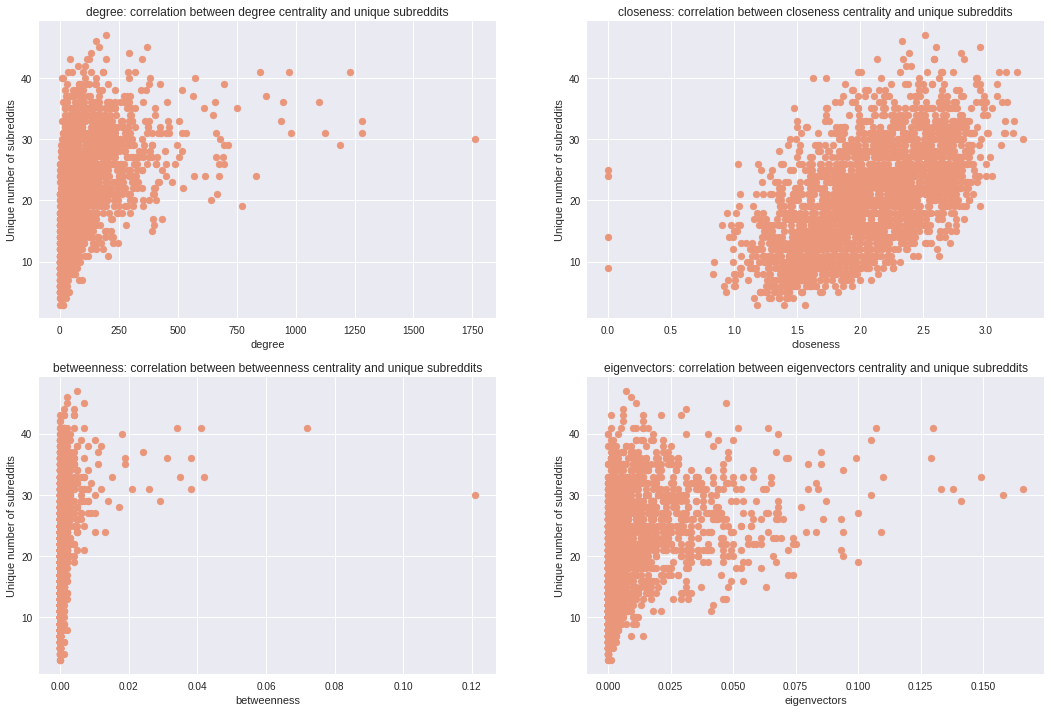

In [ ]:
n2us_dict = nodes_to_used_subreddits(df, unique=True)
n_unique_subreddits = []
for user in tops_centralities_df.user:
    n_unique_subreddits.append(len(n2us_dict[user]))

centralities = [tops_centralities_df.degree, tops_centralities_df.closeness,
                tops_centralities_df.betweenness, tops_centralities_df.eigenvectors]


figs, axs = plt.subplots(2,2, figsize=(18,12))
for i, (centrality, name, ax) in enumerate(zip(centralities, centrality_names, axs.flatten())):
    j = 0 if i < 2 else 1

    ax.scatter(centrality, n_unique_subreddits, color="darksalmon")

    ax.set_xlabel(name)
    ax.set_ylabel('Unique number of subreddits')

    ax.set_title(name + ": correlation between " + name + " centrality and unique subreddits")   

plt.show()





It appears in all cases that users with a top comment on more unique subreddits somewhat correlates with how central the user is in the network - especially with respect to closeness centrality. This is quite sensible as with every new unique subreddit, a connection is likely established to another new user (if not filtrated away in the "backbone cut"). This shortens the immediate path to that user, but potentially also to every other user, which that user connects to. For many of the other centrality scores, we see that unique number of subreddits at least serves as a lower bound for being central - there are no users with comments on fewer than 20 unique subreddits and who are still among the most central user for any of the measures. 

To finish this section we briefly look at the assortativity coefficient for B with respect to the weighted degree.


In [ ]:
print(nx.degree_assortativity_coefficient(B, weight="weight"))

-0.02403781448962321


The small negative coefficient shows that $B$ is disassortative. This indicates a very small tendency towards high degree nodes connecting to low degree nodes. 

Overall, it makes sense that this value is close to zero, when we consider that there seem to be some global popular subreddits among all the users. Low degree users as well as high-degree would then typically connect because of these contributing to these large hubs which we saw in previous sections. 

Finally, as an interesting supplement to the discussion on the Trump/Biden community structure above, we can compute the assortativity with respect to the ``from_subreddit`` attribute in $B$.

In [ ]:
print(nx.attribute_assortativity_coefficient(B, attribute="from_subreddit"))

0.21985716830400548


The coefficient shows assortativity with respect to the attribute revealing that Trump users do tend to link to other Trump users and vise versa with Biden users. Note, however, that the computation does not take weights into account. Thus, this assortativity is when considering connections between users if they have at least one subreddit in common.

## 3.3 Comparing candidate sub-networks
In this section the two subnetworks emerging from splitting the network $B$ based on ``from_subreddit`` is further investigated. These subnetworks will be refered to as the trump and biden subnetwork respectively. In this section we will be looking for differences and similarities between the two regarding simple network stats, advanced  statistics, degree distributions and finally communities within each subnetwork. 




In [ ]:
# Load the backbone network B
network_path = "drive/MyDrive/SGAI/BackBone_alpha=0.09.gpickle"
B = nx.read_gpickle(network_path) 

# Extract the two subnetworks
t_nodes = [n for n, from_subreddit in B.nodes(data='from_subreddit') if from_subreddit == "trump"]
b_nodes = [n for n, from_subreddit in B.nodes(data='from_subreddit') if from_subreddit == "biden"]

B_trump_full = B.subgraph(t_nodes).copy()
B_biden_full = B.subgraph(b_nodes).copy()


Again as discussed in 3.1.2, we are primarily interested in investigating how users are connected. Thus, we extract the most connected components

In [ ]:
subnetworks = []
for name, subnetwork in zip(["Trump subnetwork", "Biden subnetwork"], [B_trump_full, B_biden_full]):
    print(name + ":")
    # Extract the largest connected components
    CCs = list(nx.connected_components(subnetwork))

    # Print lengths
    comps = [list(comp) for comp in CCs]
    len_of_comps = sorted([len(comp) for comp in comps], reverse=True)
    print("Sizes of the connected components: ", len_of_comps)
    print("Removed nodes: ", sum(len_of_comps[1:]))
    print("Fracion of nodes: ", round(sum(len_of_comps[1:])/len(subnetwork.nodes), 2))
    print("\n")

    # Use largest component as network
    nodes_of_LC = (max(CCs, key=len))
    subnetworks.append(subnetwork.subgraph(nodes_of_LC).copy())

B_trump = subnetworks[0]
B_biden = subnetworks[1]


Trump subnetwork:
Sizes of the connected components:  [1128, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Removed nodes:  31
Fracion of nodes:  0.03


Biden subnetwork:
Sizes of the connected components:  [1148, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Removed nodes:  38
Fracion of nodes:  0.03




The extraction results in two almost equally large connected subnetworks, where only 3% of nodes are (almost) unconnected and thus removed

### 3.3.1 Network Statistics for candidate sub-networks



#### 3.3.1.1 Motive
Similar to in section 3.1.3 we want an impressions of the extracted subnetworks from the $B$ network. For each candidate's subnetwork we will compute

- Number of nodes $N$
- Number of edges $L$
- Minimum and maximum degree
- Median degree
- Mode of degrees
- Average degree $\langle k \rangle$
- Average $w$
- Minimum $w$ and maximum $w$

where $k$ is degree and $w$ weight. 

Additionally, we will 
- compare each subnetwork's most frequent subreddits within subnetworks.
- look at the subreddits who most often connects users from one subnetwork to users in the other. 











#### 3.3.1.2 Tools
Explanations of these stats/tools can be found in section 3.1.3.2

However, since we are working with subnetworks based on the network $B$, links and degrees now have a slightly different and less intuitive interpretation. As discussed in section 3.2.1; instead of removing edges below some global threshold for all users (e.g. users with less than three common subreddits), we instead set some local relative limit pr. user based on this significance $\alpha$.

The preserved links in $B$ are those who constitutes a significant amount of weight for a user, relative to the user's other links (e.g. a weight 3 might still be significant compared to a weight of 4, but maybe not compared to a weight 10). Thus, we can interpret a "raw" connection as; if two users are connected in $B$, they have a *significant number of subreddits in common*.

These connections are still weighted. Thus, the degree of user $u_i$ now have this slightly less intuitive interpretation: the sum of common subreddits with every other user $u_j$, where $u_i$ and $u_j$ have a significant number of subreddits in common. 


#### 3.3.1.3 Results and discussion


The stats are computed for the two subnetworks ``B_trump`` and ``B_biden``.

In [ ]:
# Extract unweighted degrees
degrees_trump = [d for user, d in B_trump.degree(weight="weight")]
weights_trump = [w for u, v, w in B_trump.edges(data="weight")]

# Extract all weighted degrees
degrees_biden = [d for user, d in B_biden.degree(weight='weight')]
weights_biden = [w for u, v, w in B_biden.edges(data="weight")]


# Inserting data into pandas for nice prints
df_stats = pd.DataFrame({'N':[len(B_trump.nodes), len(B_biden.nodes)],
                         'L':[len(B_trump.edges), len(B_biden.edges)],
                         'Min degree':[np.min(degrees_trump), np.min(degrees_biden)],
                         'Max degree':[np.max(degrees_trump), np.max(degrees_biden)],
                         'Median degree':[int(np.median(degrees_trump)), int(np.median(degrees_biden))],
                         'Mode degree':[Counter(degrees_trump).most_common(1)[0][0], Counter(degrees_biden).most_common(1)[0][0]],
                         '⟨k⟩':[int(round(np.mean(degrees_trump), 0)), int(round(np.mean(degrees_biden),0))],
                         'Avg w':[round(np.mean(weights_trump), 2), round(np.mean(weights_biden), 2)],
                         'Min w':[round(min(weights_trump), 2), round(min(weights_biden), 2)],
                         'Max w':[round(max(weights_trump), 2), round(max(weights_biden), 2)],
                         }, index=["Trump", "Biden"])

df_stats


,N,L,Min degree,Max degree,Median degree,Mode degree,⟨k⟩,Avg w,Min w,Max w
Trump,1128,10834,3,1351,55,3,100,5.18,3,13
Biden,1148,17210,3,2730,90,3,187,6.25,3,17


Despite that the two subnetworks consist of almost equally many users, the table shows that the Biden subnetwork is a lot more dense - it contains $\frac{10834}{17210}\cdot100\%=63$\% more links - i.e. the biden subnetwork has a lot more users with a significant number of subreddits in common. One might suspect that this difference could be caused by Biden users generally having their top 50 comments on many different subreddits - i.e. having more unique subreddits to connect upon:






In [ ]:
avg_unique_subreddits_trump = 0
avg_unique_subreddits_biden = 0


for user, used_subreddits in zip(np.array(df.user), extract_decoded_used_subreddits(df)):
    if user in B_biden.nodes():
        avg_unique_subreddits_trump += len(set(used_subreddits))
    elif user in B_trump.nodes():
        avg_unique_subreddits_biden += len(set(used_subreddits))

avg_unique_subreddits_biden = int(round(avg_unique_subreddits_biden/len(B_biden.nodes()), 0))
avg_unique_subreddits_trump = int(round(avg_unique_subreddits_trump/len(B_trump.nodes()), 0))

print("Average number of unique subreddits (Trump): ", avg_unique_subreddits_biden)
print("Average number of unique subreddits (Biden): ", avg_unique_subreddits_trump)

Average number of unique subreddits (Trump):  20
Average number of unique subreddits (Biden):  21


But the computations above show that users from the two subnetworks approximately has their top 50 comments on the same number of unique subreddits. Therefore, it is very interesting to see such differences in the two subnetworks.

Further inspection of the table shows that the Biden subnetwork has users which beter reflect the subnetwork's general common subreddits, with a max degree more than twice as large as for the trump network. Additionally, the biden network is in general more strongly connected. Both the median and average degree of users is almost twice as high to the trump network, and moreover users on average has on more subreddit in common in the Biden network, as the average weight is 1.07 higher. Finally, we see that the biden subnetwork has users which at most has 17 subreddits in common (max weight), where the trump subnetwork only has 13. However, both subnetworks has no significant connections where users has less than three subreddits in common, and also most users has degree three. 

Overall, the stats of this data indicate that users in the Biden subnetwork tend to have top comments on the same subreddit pages to a larger extent than users from the Trump subnetwork. 

This raises an interesting question - what are the most frequent subreddits among users in each subnetwork. Below, the 20 most frequent subreddits and their frequencies are extracted for each subnetwork:

In [ ]:
# Define method for printing top lists of subreddits
def get_df_with_tops(names, TF_dicts):
    subnet_topreddits_df = pd.DataFrame()
    for name, TF_dict in zip(names, TF_dicts):
        TF_list = [(s,f) for (s,f) in TF_dict if s not in ["trump", "biden", ""]]
        TF_list = sorted(TF_list, key=lambda x: x[1], reverse=True)
        subnet_topreddits_df[name] = TF_list[:20]

    return subnet_topreddits_df

unique_used_subreddits_pr_trump_user = []
unique_used_subreddits_pr_biden_user = []


for user, used_subreddits in zip(np.array(df.user), extract_decoded_used_subreddits(df)):
    if user in B_biden.nodes():
        unique_used_subreddits_pr_biden_user += list(set(used_subreddits))
    elif user in B_trump.nodes():
        unique_used_subreddits_pr_trump_user += list(set(used_subreddits))

# Use the NLTK package's inbuild freqdist to save a dict with frequencies for each subreddit
TF_trump = nltk.FreqDist(unique_used_subreddits_pr_trump_user).items()
TF_biden = nltk.FreqDist(unique_used_subreddits_pr_biden_user).items()
subnet_topreddits_df = pd.DataFrame()

for name, TF_dict in zip(["Trump", "Biden"], [TF_trump, TF_biden]):
    TF_list = [(s,f) for (s,f) in TF_dict if s not in ["trump", "biden", ""]]
    TF_list = sorted(TF_list, key=lambda x: x[1], reverse=True)
    subnet_topreddits_df[name] = TF_list[:20]

top_df = get_df_with_tops(["Trump", "Biden"], [TF_trump, TF_biden])
top_df

,Trump,Biden
0,"(Conservative, 473)","(Politics, 716)"
1,"(Ask Reddit..., 459)","(Ask Reddit..., 547)"
2,"(Reddit Pics, 249)","(All news, US and international., 423)"
3,"(funny, 238)","(World News, 394)"
4,"(All news, US and international., 222)","(Reddit Pics, 347)"
5,"(Politics, 212)","(Today I Learned (TIL), 282)"
6,"(/r/PublicFreakout, 201)","(funny, 260)"
7,"(/r/Memes the original since 2008, 189)","(/r/PublicFreakout, 227)"
8,"(World News, 181)","(Novel Coronavirus (COVID-19), 187)"
9,"(Today I Learned (TIL), 173)","(A subreddit for cute and cuddly pictures, 186)"


This reveals some very interesting results. First of all, we notice a lot of the geneally popular subreddits like "Ask Reddit...", "Today I Learned (TIL)" etc. within both subnetworks. 

There seem to be some interests of republican politics among the users in Trump subnetwork. These users often have top comments on the [conservative](https://www.reddit.com/r/Conservative/) subreddit, which writes the following in their description: "The place for Conservatives on Reddit". Other indicators are index 16, "Tucker Carlson: The Sworn Enemy of Lying, Pomposity, Smugness & Groupthink" who, citing his [wikipedia](https://en.wikipedia.org/wiki/Tucker_Carlson#Views_on_Republicans_and_Democrats) page, "*has been described by Politico as "perhaps the highest-profile proponent of Trumpism*". This kind of indications are less prominent among the users in the Biden subnetwork, with the only one being [2020 Political Hindsight - a Donald Trump lovefest](https://www.reddit.com/r/PoliticalHumor/) impicitly. The description says "*A subreddit focused on US politics, and the ridiculousness surrounding them.*" which together with the title somewhat implies these users are opposed to Trump. Besides from that, it generally seem like users who have top comments on the Biden subreddit is generally also very active on various political subreddit, e.g. "Politics", "All news, US and international", "World news" etc.

Apart from the subreddits with political implications, there are a couple of funny observations. "conspiracies" is one of the most represented subreddit among top comments of users in the Trump network whereas "Novel Coronavirus (COVID-19)" is among the Biden subnetwork.


An interesting experiment is to filtrate out the top 100 subreddits mentioned in section **2.X??**. This is done for each subnetwork below using the ``string`` and ``re`` (regular expressions) modules. Note that a lot of small changes are required in order to make titles match for subreddits, as these may change names over time.


In [ ]:
def remove_top100_subreddits(TF_dict, top100):
      removed = []
      # Convert to list without the biden trump and empty subreddits
      TF_list = [(s,f) for (s,f) in TF_dict if s not in ["trump", "biden", ""]]
      no_top100_TF_list = []

      # Loop over all subreddits in list
      for (s,f) in TF_list:
          is_top_100 = False
          # Make titles fit
          s_form = s.replace("r/", "")
          s_form = s_form.replace("(TIL)", "")
          s_form = re.sub("[^0-9a-zA-Z]+", "", s_form)
          
          #Check if subreddit matches with a top100 subreddit
          for s_100 in top100:
              s_100 = re.sub("[^0-9a-zA-Z]+", "", s_100)
              is_top_100 = s_form.lower() == s_100.lower()
              if is_top_100:
                  removed.append((s, f, "--", s_100))
                  break

          # Add all subreddits which are not in top 100 subreddits       
          if not(is_top_100):
              no_top100_TF_list.append((s,f))

      return no_top100_TF_list, removed



non_top100_trump, removed_trump = remove_top100_subreddits(TF_trump, top100_subreddits)
non_top100_biden, removed_biden = remove_top100_subreddits(TF_biden, top100_subreddits)

# Print
top_df = get_df_with_tops(["Trump", "Biden"], [non_top100_trump, non_top100_biden])
top_df

,Trump,Biden
0,"(Conservative, 473)","(All news, US and international., 423)"
1,"(Reddit Pics, 249)","(Reddit Pics, 347)"
2,"(All news, US and international., 222)","(/r/PublicFreakout, 227)"
3,"(/r/PublicFreakout, 201)","(Novel Coronavirus (COVID-19), 187)"
4,"(/r/Memes the original since 2008, 189)","(A subreddit for cute and cuddly pictures, 186)"
5,"(A subreddit for cute and cuddly pictures, 157)",(2020 Political Hindsight - a Donald Trump lov...
6,"(For your Opinions that are Unpopular , 145)","(Movie News and Discussion, 177)"
7,"(conspiracy, 138)","(White People Twitter, 159)"
8,"(Tucker Carlson: The Sworn Enemy of Lying, Pom...","(Sadly, this is not the Onion., 149)"
9,"(All things Trashy!, 120)","(.gifs - funny, animated gifs for your viewing..."


This reveals a couple more subreddits which somewhat implies political beliefs, e.g. 16. "AskThe_Donald" as well as 12. "The Ideological Trashcan" (which seem to be a liberal oriented subreddit also known as "r/neoliberal"). Moreover, it revealed a couple more interesting observations; that gun politics (index 17) is a popular subreddit among users in the Trump subnetwork and atheism (index 18) is among users of the Biden subnetwork.

However, we see that there are still many 'neutral' subreddits like "Reddit Pics" and "PublicFreakout" who appears in the lists. As another supplement to this work, it would be informative to analyse these networks where these generally common/neutral subreddits where removed. However, this introduces a lot of bias in when and how to evaluate a subreddit as neutral. E.g. in our case, it might indicate something, that "Politics" is the number one top subreddit for the Biden subnetwork, and number five among the Trump. And furthermore, what would it mean if "Ask Reddit..." where a lot more popular among one type of users compared to another?

Finally, we'll investigate the subreddits who most frequently connects users in

In [ ]:
cross_common_subreddits = []
# Make list of all subreddits which connects users
for u, v, subr in B.edges(data="common_subreddits"):
    if B.nodes[u]["from_subreddit"] != B.nodes[v]["from_subreddit"]:
        cross_common_subreddits += subr
        
# Count unique occurences and sort
TF_cross = nltk.FreqDist(cross_common_subreddits)
n_links = TF_cross.N()
TF_list = [(s,round(f/n_links, 2)) for (s,f) in TF_cross.items()]
TF_list = sorted(TF_list, key=lambda x: x[1], reverse=True)

# Print
cross_pd = pd.DataFrame(TF_list[:20], columns=["Subreddit", "Frequency (%)"])
cross_pd

,Subreddit,Frequency (%)
0,Ask Reddit...,0.09
1,Reddit Pics,0.06
2,Politics,0.05
3,funny,0.05
4,"All news, US and international.",0.05
5,World News,0.04
6,Today I Learned (TIL),0.04
7,/r/PublicFreakout,0.03
8,r/gaming,0.02
9,Movie News and Discussion,0.02


We see that it is generally the very popular and neutral subreddits which connects the two subnetworks. Additionally, politic and news related subreddits seem to appear frequently among both type of users, which is sensible considering we originally found them from comments on presedential candidates - hence it makes sense that the group considered above are of users engaging in these news and poltic related subreddits.  

### 3.3.2 Degree Distributions and the Network types


#### 3.3.2.1 Motive
Now the subnetworks are examined for whether extracting them from $B$ conserves the scale-free appearence of $B$ for both subnetworks. This will reveal whether they are still charactized by having hubs - i.e. users who most other users tend to have many subreddits in common with. 

#### 3.3.2.3 Tools
Most of the relevant theory is already described in section 3.1.3.2. It is worth mentioning that some studies [Michael P. H. Stumpf et al.](https://www.pnas.org/content/102/12/4221) suggests that subnetworks of scale-free networks are not scale-free, if nodes are randomly drawn from the subnetwork with some probability. However, the paper does not state explicitly whether this is specific to unweighted scale-free networks, or if it also generalizes to weighted scale-free networks. Note also that they are more strict in terms of statistical significane when describing a network as scale-free, as opposed to this work where we primarily consider general (visual) tendencies.

#### 3.3.2.3 Results and discussion

We immediately extract the degree distributions for the two subnetworks, and plot them on both the linear and log-log scale next to the original network $B$

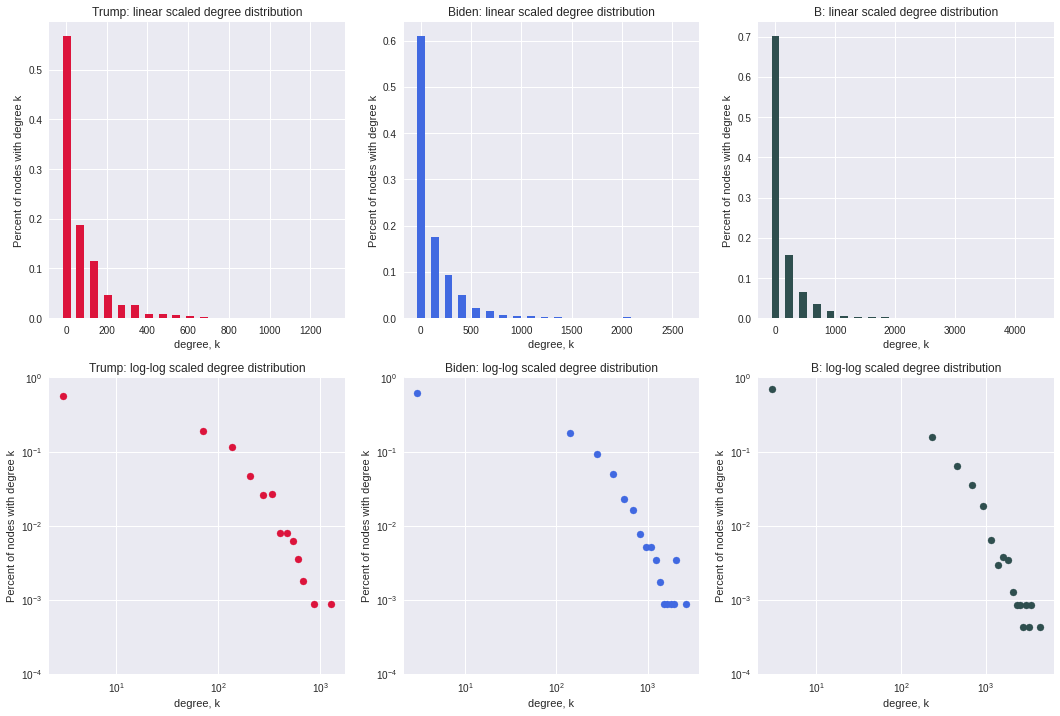

In [ ]:

def plot_degree_dists(degrees_list, name_list, colors):

    figs, axs = plt.subplots(2,3, figsize=(18,12))

    n_bins = 20

    for i, (degrees, names) in enumerate(zip(degrees_list, name_list)):
        count, bins = np.histogram(degrees, bins=n_bins)
        xbins=bins[:len(bins)-1]
        probs = count/sum(count)


        axs[1][i].set_xscale("log")
        axs[1][i].set_yscale("log")
        axs[1][i].set_ylim(1e-4,1)
        axs[1][i].scatter(xbins, probs, color=colors[i])

        axs[0][i].bar(xbins, probs, max(degrees)/35, color=colors[i])

        for j in range(2):
          axs[j][i].set_xlabel('degree, k')
          axs[j][i].set_ylabel('Percent of nodes with degree k')

        axs[0][i].set_title(name_list[i] + ": linear scaled degree distribution")   
        axs[1][i].set_title(name_list[i] + ": log-log scaled degree distribution")   
    plt.show()

degrees_biden = [w for (d, w) in B_biden.degree(weight="weight")]
degrees_trump = [w for (d, w) in B_trump.degree(weight="weight")]
degrees = [w for (d, w) in B.degree(weight="weight")]

colors = ["crimson", "royalblue", "darkslategray"]
plot_degree_dists([degrees_trump, degrees_biden, degrees], ["Trump", "Biden", "B"], colors)

It appears that both subnetworks' degrees are distributed very similar to $B$ (see section 3.2.1.3) and therefore both subnetworks seem to greatly conserve the distribution - especially from inspecting the log-log scale plot. Like with $B$, the degrees still seem to somewhat follow a power-law distribution and we can see a presence of hubs for both subnetworks.

Again, by using the Python library `powerlaw` we can find the best power-law fit to our degree distributions and report the degree exponent $\gamma$:

In [ ]:
# Fit to each degree distribution
fits = []
for degs in [degrees_trump, degrees_biden, degrees]:
    fits.append(powerlaw.Fit(degs))
   

Calculating best minimal value for power law fit
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


In [ ]:
for fit, name in zip(fits, ["Trump", "Biden", "B"]):
    gamma = fit.alpha
    print(f"{name}:  Gamma={round(gamma, 2)} \n")

Trump:  Gamma=6.45 

Biden:  Gamma=3.08 

B:  Gamma=3.22 



We find that $\gamma>3$ for both cases which still places the subnetworks in the random network regime. For the Biden subnetwork, $\gamma$ is slightly less than for $B$, which indicates that "extreme" degrees are a little more likely observed in the Biden network. In opposition to this, $\gamma$ for the Trump subnetwork is a lot higher, revealing that extreme outcomes in the Trump network is less likely to be observed. These two results are in fine correspondence with previous observation; that the Biden network is a lot more dense than the Trump network.

It would be interesting to briefly look at how a random extraction (of similar size to the two subnetworks) of $B$ would emerge. Thus we can study superficially whether this somewhat conservation of the distributions appearance is trivial from a random extraction of weighted subnetworks.


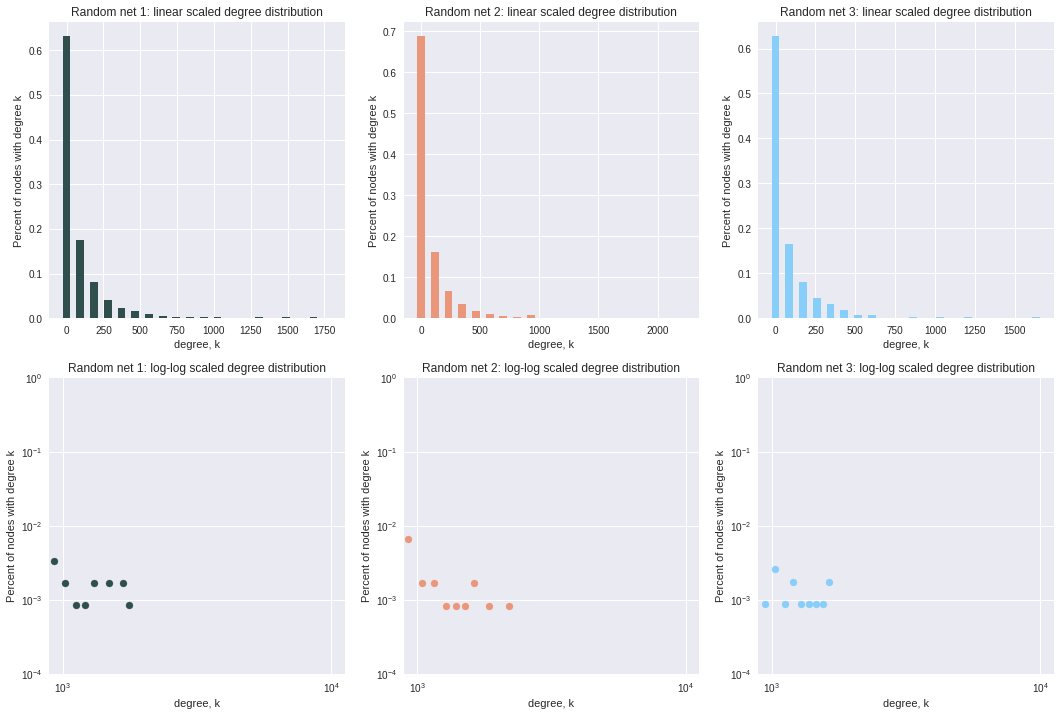

In [ ]:
# Extract three random subnetworks of B
random_degrees = []
for i in range(3):
    random_nodes = [n for n in B.nodes() if np.random.uniform(0,1) > 0.5]
    B_random = B.subgraph(random_nodes).copy()
    random_degrees.append([w for (d, w) in B_random.degree(weight="weight")])


# plot them
colors = ["darkslategray", "darksalmon", "lightskyblue"]
plot_degree_dists(random_degrees, ["Random net 1", "Random net 2", "Random net 3"], colors)


Although plots on the linear scale seem similar to the previous plots, the degree distribution on the log-log appear quite different from before. This suggests for our case that that the scale-free appearance of the weighted degree distribution is not very well preserved when extracting a random subnetwork. 

This implies that the attribute ``from_subreddit`` seem to somewhat reflect a structure in $B$, which deviates from randomness. Whether this is an indication of some sort of community structure is difficult to tell. Although it does not introduce obvious bias, it might have an impact on these obseration that the data is collected from the two subreddit pages which we now divide the network accordingly to. In future work it would be interesting to further investigate differences in properties of subnetworks which respectively conserves and doesn't conserve appearence of degree distributions.  

Finally, the positions of the nodes are computed using the ``ForceAtlas2`` module as before.

In [ ]:
# Calculate position with the ForceAtlas2 algorithm
forceatlas2 = ForceAtlas2(outboundAttractionDistribution=True,  # Dissuade hubs
                          edgeWeightInfluence=1.0,
                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          # Tuning
                          scalingRatio=2.0,
                          strongGravityMode=False,
                          gravity=0.1,
                          # Log
                          verbose=True)

pos_trump = forceatlas2.forceatlas2_networkx_layout(G=B_trump, pos=None, iterations=2000)
pos_biden = forceatlas2.forceatlas2_networkx_layout(G=B_biden, pos=None, iterations=2000)

node_sizes_trump = [(d+1)/10 for (n, d) in B_trump.degree(weight="weight")]
node_sizes_biden = [(d+1)/10 for (n, d) in B_biden.degree(weight="weight")]

  0%|          | 0/2000 [00:00<?, ?it/s]

BarnesHut Approximation  took  5.38  seconds
Repulsion forces  took  18.16  seconds
Gravitational forces  took  0.17  seconds
Attraction forces  took  0.45  seconds
AdjustSpeedAndApplyForces step  took  0.54  seconds


100%|██████████| 2000/2000 [00:30<00:00, 65.46it/s]

BarnesHut Approximation  took  5.91  seconds
Repulsion forces  took  22.40  seconds
Gravitational forces  took  0.13  seconds
Attraction forces  took  0.74  seconds
AdjustSpeedAndApplyForces step  took  0.55  seconds


And then plotted

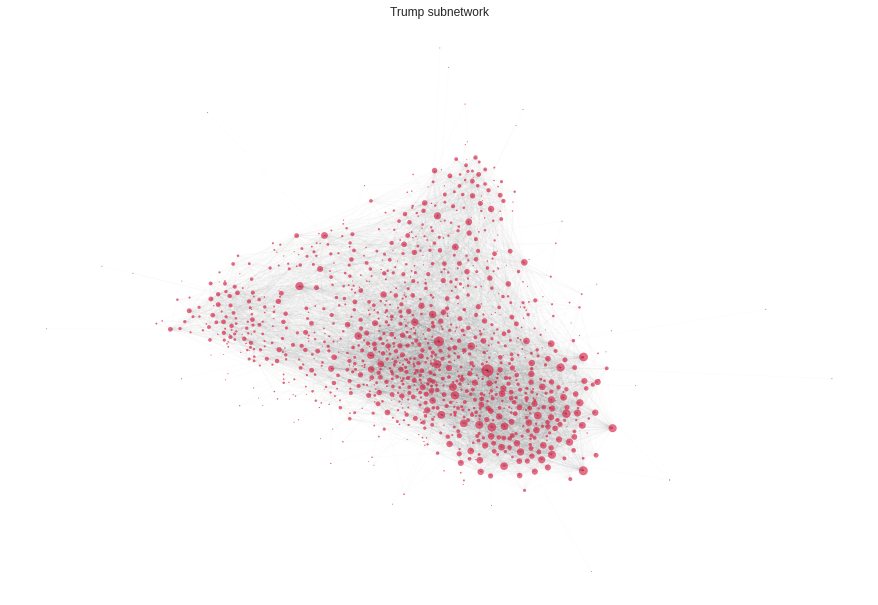

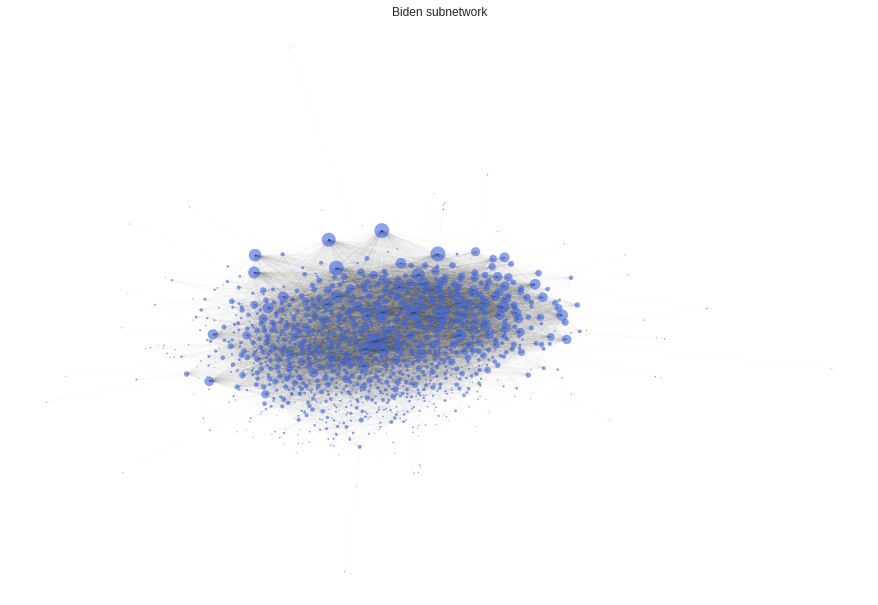

In [ ]:
fig = plt.figure(figsize=(12, 8))
nx.drawing.nx_pylab.draw(B_trump, pos=pos_trump, node_color="crimson", node_size=node_sizes_trump, with_labels=False, edge_color='white', alpha=.6)
nx.drawing.nx_pylab.draw(B_trump, pos=pos_trump, node_color="crimson", node_size=node_sizes_trump, with_labels=False, edge_color='black', alpha=.01)
plt.title("Trump subnetwork")
plt.show()

fig = plt.figure(figsize=(12, 8))
nx.drawing.nx_pylab.draw(B_biden, pos=pos_biden, node_color="royalblue", node_size=node_sizes_biden, with_labels=False, edge_color='white', alpha=.6)
nx.drawing.nx_pylab.draw(B_biden, pos=pos_biden, node_color="royalblue", node_size=node_sizes_biden, with_labels=False, edge_color='black', alpha=.01)
plt.title("Biden subnetwork")
plt.show()


When comparing the two plots we see that the Biden subnetwork appears more compact. This makes sense when considering that strongly connected nodes are placed closer to each other in force directed drawing algorithms. Recall that we previously saw that nodes on average were more connected and with greather weights in the Biden subnetwork.

### 3.3.3 Community detection within partitions
 

#### 3.3.3.1 Motive

After having considered communities on the global network the attention is now turned within the partionings into `trump` and `biden`. It is interesting to see if we can find community structures with a reasonable level of modularity within these partitions as this would yield information on the diversity of the users of each subreddit. It could be imagined that there could be communities in either partitioning for which both political and apolitical interests differ. 

Also this will add to the pursuing text analysis in section 3.4 as we will be able to consider both global and more localized analyses of comments. 

#### 3.3.3.2 Tools

For the community detection we again be utilizing the Louvain algorithm which was presented in section 3.2.2.2. 

Apart from the modularity score which will be evaluated in term of significance, we will also evaluate the community structure in either subgraph from a density point of view following the sense of community described by hypothesis H2 (Barabasi, 9.2). 

Finally we will present the 20 most commonly appearing subreddits in the found communities and see which informations can be drawn out from looking at these. 

#### 3.3.3.3 Results and discussion

We commence by again loading the backbone network $B$ and partitioning it into two subgraphs consisting of the nodes found on respectively r/DonaldTrump and r/JoeBiden:

In [ ]:
Bpath = "/content/drive/MyDrive/SGAI/BackBone_alpha=0.09.gpickle"

In [ ]:
def get_subgraph_from_subreddit(network, from_subreddit):
  nodes = [u for u, subreddit in B.nodes.data(data="from_subreddit") if subreddit == from_subreddit]
  return network.subgraph(nodes)

def lcc(network):
  connected_components = nx.connected_components(network)
  network = network.subgraph(list(max(connected_components, key=len)))
  return network

In [ ]:
# Load B graph
B = nx.read_gpickle(Bpath)

# Get the largest connected components of Trump and Biden subgraphs
Btrump = lcc(get_subgraph_from_subreddit(B, "trump"))
Bbiden = lcc(get_subgraph_from_subreddit(B, "biden"))

NBtrump, LBtrump = len(Btrump.nodes), len(Btrump.edges)
NBbiden, LBbiden = len(Bbiden.nodes), len(Bbiden.edges)

counts = { "Nodes":[NBtrump, NBbiden], "Edges":[LBtrump, LBbiden]}
dfview = pd.DataFrame(counts, index=["Btrump", "Bbiden"])
dfview

,Nodes,Edges
Btrump,1128,10834
Bbiden,1148,17210


We see that there are an almost equal amount of nodes in the largest connected components of the two subgraphs, where as the $B_{biden}$ has $\approx 6,400$ more edges than the $B_{trump}$ subgraph, which would indicate that the users from the Biden subreddit has generally speaking more in common than the users on the Trump subreddit. 

We now use the Louvain algorithm implemented in `best_partition` to find the partitioning on the two subgraphs that yields the highest modularity and compute the value of the modularity of this partitioning:

In [ ]:
def partition_and_modularity(network, state):
  partition = community.best_partition(network, random_state=state)
  modularity = community.modularity(partition, network)
  return partition, modularity

Btrump_partition, Btrump_modularity = partition_and_modularity(Btrump, state=1)
Bbiden_partition, Bbiden_modularity = partition_and_modularity(Bbiden, state=1)

In [ ]:
tnoc = len(set(Btrump_partition.values()))
bnoc = len(set(Bbiden_partition.values()))
stats = { "Number of communities":[tnoc, bnoc], "Modularity":[Btrump_modularity, Bbiden_modularity]}
dfview = pd.DataFrame(stats, index=["Btrump", "Bbiden"])
dfview

,Number of communities,Modularity
Btrump,6,0.404737
Bbiden,6,0.265512


We observe that the Louvain algorithm terminates at a partitioning into 6 communities on both subgraphs. 

It can be seen that the modularity is highest ($\approx 0.40$) in the partitioning on $B_{trump}$. The modularity of partitioning on $B_{biden}$ is rather low ($\approx 0.27$), even slightly lower than what Newman points to as significant community structure in practise which he suggests is around the level of 0.3 (Newman 2003, p.1). 

This may also have something to do with the fact  that the Biden subgraph is relatively more dense than the Trump subgraph. This means that every node has in general rather much in common with every other node in the network, making it hard to detect clear cut communities. 

In order to give another impression of the level of community structure, we can also consider the density hypothesis for communities H2 (Barabasi, 9.2) which says that a community is a locally dense connected subgraph in a network. 

One can convert this intuition into two equalities:

$$
\begin{align}
\text{Strong community}&:\quad \forall_i \hspace{0.2cm} k_{i}^{int}(C) > k_{i}^{ext}(C) \quad \text{(Barabasi, eq 9.1)} \\
\\
\text{Weak community}&:\quad \hspace{0.2cm} \sum_i k_{i}^{int}(C) > \sum_i k_{i}^{ext}(C) \quad \text{(Barabasi, eq 9.2)}
\end{align}
$$

where $k_{i}^{int}(C)$ denotes the degree of node $i$ internally to $C$, meaning the the links inside community $C$ and $k_{i}^{int}(C)$ denotes the degree of node $i$ externally to $C$ meaning the the links going outside community $C$ (Barabasi, 9.2).

In the present context we will extend these equalities to use the weighted degree for $k_i$. 

This means that the strong community condition is saying that every node in a given community C must have more in common with nodes in C than with any other nodes. The weak community condition on the other hand just says that in total the nodes in community C must have more in common than they have in common with other nodes in total. 

The following helper function are first implemented to help carry out the analyses of this section, which is a mapping from a community partition onto the nodes of the community:

In [ ]:
def communities_to_nodes(partition):
  communities_to_nodes = {}

  community_names = set([v for k, v in partition.items()])
  for name in community_names:
    nodes = [key for key, value in partition.items() if value==name]
    communities_to_nodes[name] = nodes
  
  return communities_to_nodes

The following function maps each community to a list of the internal and external degrees of each node in the community:

In [ ]:
def community_to_degrees(network, partition,weighted=True):
  community_to_degrees = collections.defaultdict(dict)
  c2n = communities_to_nodes(partition)
  nnodes = 0

  for community, community_nodes in c2n.items():
    k_int_C = []
    k_ext_C = []
    for i in community_nodes:
      nnodes += 1
      k_int = 0
      k_ext = 0 
      for j in network[i]:
        if j in community_nodes:
          if weighted:
            k_int += network[i][j]["weight"]
          if not weighted:
            k_int += 1
        else:
          if weighted:
            k_ext += network[i][j]["weight"]
          elif not weighted:
            k_ext += 1

      k_int_C.append(k_int)
      k_ext_C.append(k_ext)

    community_to_degrees[community]["int"] = k_int_C
    community_to_degrees[community]["ext"] = k_ext_C
  return community_to_degrees

In [ ]:
tc2d = community_to_degrees(Btrump, Btrump_partition, weighted=True)
bc2d = community_to_degrees(Bbiden, Bbiden_partition, weighted=True)

# sanity check
total_weighted_degree_subgraph = sum( [wd for _,wd in Btrump.degree(weight="weight")])
total_weighted_degree_communities = sum([sum(deg_type["int"]) + sum(deg_type["ext"]) for _, deg_type in tc2d.items()])

assert total_weighted_degree_subgraph == total_weighted_degree_communities

Now we can implement `community_to_type` which maps a community to the strongest condition from H2 that it satisfies:

In [ ]:
def community_to_type(community_to_degrees):
  community_to_type = {}
  for community, deg_type in community_to_degrees.items():
    condition_1 = all([ k_int > k_ext for k_int, k_ext in zip(deg_type["int"], deg_type["ext"]) ]) # Barabasi, eq. 9.1
    condition_2 = sum([k_int for k_int in deg_type["int"]]) > sum([k_ext for k_ext in deg_type["ext"]]) # Barabasi, eq. 9.2

    if condition_1:
      community_to_type[community] = "strong"
    elif condition_2:
      community_to_type[community] = "weak"
    else:
      community_to_type[community] = "neither"
  return community_to_type

This enables an investigation of the strength of the found communities:

In [ ]:
trump_communities_to_type = community_to_type(tc2d)
biden_communities_to_type = community_to_type(bc2d)
t = [(k,v) for k, v in trump_communities_to_type.items()]
b = [(k,v) for k, v in biden_communities_to_type.items()]

cols = ["Trump communites", "Biden communities"]
stat = [[elem[0], elem[1]] for elem in zip(t,b)]

dfview = pd.DataFrame(data=stat, columns=cols)
dfview

,Trump communites,Biden communities
0,"(0, neither)","(0, weak)"
1,"(1, weak)","(1, neither)"
2,"(2, weak)","(2, weak)"
3,"(3, neither)","(3, weak)"
4,"(4, weak)","(4, neither)"
5,"(5, weak)","(5, weak)"


This investigation shows that the density sense of the communities are at most weak and some of them don't satisfy even the weak criterion of H2. This investigation combined with the fact that the modularity scores also are relatively low suggests that we should not expect to see very clear communities. 

With this in mind, we can turn to investigate the properties of the found communities on the two subgraphs. First we will plot the sizes of the communities: 

In [ ]:
def get_community_sizes(partition):
  D = partition
  communities = set(D.values())
  community_sizes = []
  for k in range(len(communities)):
    size = sum(map((k).__eq__, D.values()))
    community_sizes.append(size)
  return community_sizes

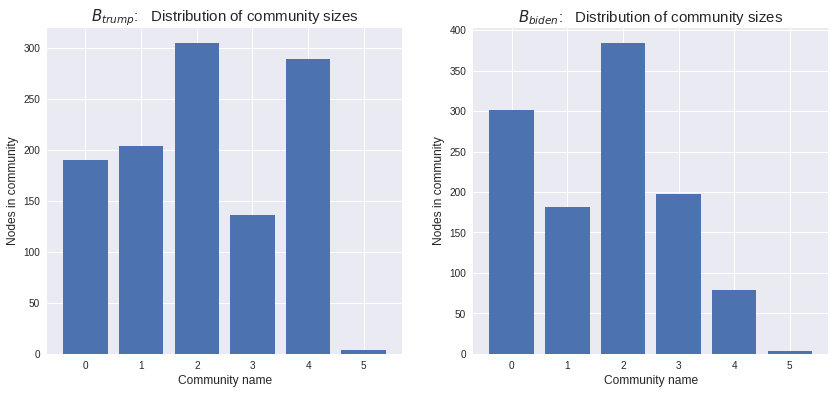

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
partitions = [Btrump_partition, Bbiden_partition]
titles = ["$B_{trump}$", "$B_{biden}$"]
for idx, ax in enumerate(axes):
  title = titles[idx] + ":   Distribution of community sizes"
  names = list(set([v for k, v in partitions[idx].items()]))
  sizes = get_community_sizes(partitions[idx])
  ax.bar(x=names, height=sizes)
  ax.set_title(title, fontsize=15)
  ax.set_xlabel("Community name", fontsize=12)
  ax.set_ylabel("Nodes in community", fontsize=12)

The community size distributions are quite similar in the sense that four of the communities contain over 150 nodes. 

The Louvain algorithm is able to detect and preserve smaller communities (Blondel et. alia 2008, p. 5) through its iterations, which is a feature that helps bettering the so-called resolution limit where some communities disappear as the modularity can sometimes be increased by merging smaller communities into larger in unfortunate ways with regards to discovering small community structures in real networks (Barabasi, 9.4) (Heshe, Græsholt & Tommerup, assignment 2). 

As we see in both partitionings community 5 is detected and preserved even if it is quite small compared to the other communities. 

Now we will investigate which subreddits the users in each of the communities are commenting on. 

To that end we introduce the mapping `nodes_to_used_subreddits` that maps the node names (i.e. user names) to the data attribute `used_subreddits` and the function `topreddits` that extracts a number of most frequent `used_subreddits` controlled by the parameter `level`:

In [ ]:
def nodes_to_used_subreddits(dataframe):
  users = [u for u in dataframe["user"]]
  used_subreddits = [json.loads(us) for us in dataframe["used_subreddits"]]
  n2us = {}
  for u, us in zip(users, used_subreddits):
    n2us[u] = us
  return n2us

def topreddits(network, dataframe, partition, level):
  c2n = communities_to_nodes(partition)
  n2us = nodes_to_used_subreddits(dataframe)
  communities_to_topreddits = {}
  for community, nodes in c2n.items():
    subgraph = network.subgraph(nodes)
    community_subreddits = []
    for node in subgraph:
      used_subreddits = n2us[node]
      for used_subreddit in used_subreddits:
        if not used_subreddit in ["trump", "biden"]:
          community_subreddits.append(used_subreddit)
    
    counter = Counter(community_subreddits)
    topreddits = counter.most_common(level)
    communities_to_topreddits[community] = topreddits

  return communities_to_topreddits

Next we read in the data frame and run extract the twenty most commonly appearing subreddits in each for the communities:

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/SGAI/data_all_merged.csv", sep=";")

level=20
trump_topreddits = topreddits(Btrump, df, Btrump_partition, level=level)
biden_topreddits = topreddits(Bbiden, df, Bbiden_partition, level=level)

The next two helper functions are introduced to present the results in a nice pandas DataFrame view:

In [ ]:
def zip_values(topreddits, level):
  zipped_values = []
  for idx in range(level):
    reddits_at_idx = []
    for topredditlist in topreddits.values():
      try:
        reddits_at_idx.append(topredditlist[idx])
      except IndexError:
        reddits_at_idx.append(("na",None))

    zipped_values.append(reddits_at_idx)

  return zipped_values

def dataframe_format(topreddits):
  assert len(topreddits)>0, "Level must be larger than zero."

  level = len(topreddits[0])
  data = zip_values(topreddits, level)
  cols = [k for k in topreddits.keys()]

  return data, cols

First we consider the communities in the Trump subgraph, $B_{trump}$:

In [ ]:
tdata, tcols = dataframe_format(trump_topreddits)
tdf = pd.DataFrame(data=tdata, columns=tcols)
tdf.index = np.arange(1, level+1)
tdf

,0,1,2,3,4,5
1,"(Politics, 499)","(Conservative, 1470)","(Ask Reddit..., 1168)","(Conservative, 395)","(/r/Memes the original since 2008, 719)","(SKOL, 24)"
2,"(Conservative, 425)","(Tucker Carlson: The Sworn Enemy of Lying, Pom...","(Conservative, 598)","(Ask Reddit..., 151)","(Political Compass Memes, 492)","(Conservative, 16)"
3,"(Ask Reddit..., 352)","(WalkAway, 193)","(funny, 408)","(Watch People Die Inside, 132)","(dankmemes, 432)","(NFL: National Football League Discussion, 10)"
4,"(conspiracy, 147)","(AskThe_Donald, 188)","(Reddit Pics, 388)","(/r/PublicFreakout, 126)","(Conservative, 407)","(Showerthoughts, 8)"
5,"(/r/PublicFreakout, 144)","(conspiracy, 166)","(All news, US and international., 379)","(funny, 102)","(Ask Reddit..., 349)","(Dark Souls 2, 8)"
6,"(All news, US and international., 134)",(All posts must be related to gun politics; ci...,"(Today I Learned (TIL), 260)","(Interesting As Fuck, 101)","(For your Opinions that are Unpopular , 194)","(World of Warcraft, 7)"
7,(2020 Political Hindsight - a Donald Trump lov...,"(Steven Crowder, 150)","(r/gaming, 241)","(Am I the Asshole? , 97)","(r/teenagers, 181)","(WoW: Classic, 6)"
8,"(World News, 93)","(Ask Reddit..., 134)","(Politics, 223)","(What Could Possibly Go Wrong?, 92)","(/r/PewdiepieSubmissions, 177)","(r/gaming, 5)"
9,"(ActualPublicFreakouts, 83)",(ConservativesOnly -- If you are a conservativ...,"(World News, 206)","(/r/Memes the original since 2008, 91)",(PrequelMemes - Memes of the Star Wars Prequel...,"(Dark Souls 3, 5)"
10,"(Insane People on Facebook, 81)","(ActualPublicFreakouts, 94)","(WTF?!, 201)","(All things Trashy!, 85)","(ShitPoliticsSays, 128)","(Total Wareddit, 5)"


Comparing the results above it seems at first glance that the found most commonly appearing subreddits are quite similar to the ones found in the communities on the entire graph $B$ in section 3.2.2.3. 

Some interesting things can be pointed out:

1. The larger communities seem to be composed of a rather similar set of subreddits like `Ask Reddit`, `Conservative`, `Politics`, `PublicFreakout` and `Conspiracy` to name a few that jumps into the eyes as repetitions. 

2. The subreddit `Conservative` is a top scoring scoring subreddits on all the communities, which would indicate that the users in $B_{trump}$ in general has been active on this subreddit and that we would argue that Republicans are politically conservative. 

3. Community 1 seems to have captured the users which share an interest in fire arms: Subreddits like `Firearms`, `Gun Politics` and `All posts must be related to gun politics...` (also known as r/progun).  

4. Community 4 seems to have a more consistent interest in the internet phenomenon known as "memes" as several subreddits pertain to this phenomenon in various forms. 

5. Community 5 which is the small community consists of people active on subreddits about video games like `Dark Souls` and `World of Warcraft` and sports with `NFL...` and also `SKOL`. The top scorer is the subreddit for NFL team Minnesota Vikings called `SKOL` because of their fans' chants: Skol is apparently the Americanized version of the Danish word "skål". 

The community described in point 5 seem to be qualitatively very similar to community 5 found on the whole graph in section 3.2.2.3, which was also seen to consist only of people from the Trump subreddit. 

Next we will take a look at the top 20 most commonly appearing subreddits in the communities found on the Biden subgraph $B_{biden}$:

In [ ]:
bdata, bcols = dataframe_format(biden_topreddits)
bdf = pd.DataFrame(data=bdata, columns=bcols)
bdf.index = np.arange(1, level+1)
bdf

,0,1,2,3,4,5
1,"(Politics, 651)","(Politics, 1113)","(Politics, 2425)","(Ask Reddit..., 1064)","(Politics, 491)","(Politics, 70)"
2,"(Ask Reddit..., 650)","(Ask Reddit..., 330)","(The Ideological Trashcan, 596)","(Politics, 760)","(Ask Reddit..., 185)","(The Ideological Trashcan, 21)"
3,"(/r/Memes the original since 2008, 274)","(All news, US and international., 201)","(Ask Reddit..., 502)","(World News, 351)","(Novel Coronavirus (COVID-19), 125)","(North Carolina, 18)"
4,"(funny, 217)","(World News, 165)","(All news, US and international., 413)","(Reddit Pics, 310)","(NBA, 80)","(Maine Related News & Discussion - r/Maine, 9)"
5,"(/r/PublicFreakout, 214)",(2020 Political Hindsight - a Donald Trump lov...,"(Enough_Sanders_Spam, 320)","(All news, US and international., 272)","(All news, US and international., 78)","(Vote Blue - Vote for Democrats!, 8)"
6,"(All news, US and international., 210)","(The Ideological Trashcan, 101)","(/r/PublicFreakout, 306)","(funny, 268)","(World News, 64)","(South Carolina News and Discussion, 6)"
7,"(A subreddit for cute and cuddly pictures, 205)","(Movie News and Discussion, 90)","(World News, 295)","(Today I Learned (TIL), 242)","(NFL: National Football League Discussion, 59)","(Once in a blue moon..., 4)"
8,"(Reddit Pics, 198)","(Reddit Pics, 89)","(Novel Coronavirus (COVID-19), 293)","(/r/videos, 213)","(Movie News and Discussion, 52)","(Georgia, USA, 4)"
9,"(World News, 156)","(funny, 83)",(2020 Political Hindsight - a Donald Trump lov...,"(Movie News and Discussion, 147)","(Teachers, 51)","(I never thought leopards would eat MY face, 3)"
10,"(Today I Learned (TIL), 143)","(Novel Coronavirus (COVID-19), 79)","(Am I the Asshole? , 165)","(r/gaming, 132)","(/r/Memes the original since 2008, 42)","(Texas, 3)"


Again we see many subreddits that also had a large presence in the communities found on the whole graph in section 3.2.2.3 and it is also to a large degree very generic subreddits known from the top 100 of all subreddits.  

We can point out some observations that can be made from these communities:

1. All the communities seem to be very qualitatively alike. For example are the top scorers in the communities are generally `Politics` and `Ask Reddit`. 

2. The subreddit `The Ideological Trashcan` is present in top 2 communities 2 and 5 and is also seen in community 1. Looking into this subreddit on Google, it turns out that it is actually the subreddit `neoliberal` which it makes sense that people interested in Biden would be interested in as the Democrats is considered the liberal party in America. 

3. The subreddit `I never thought leopards would eat MY face` is present twice. This is a parody of Trump voters (check https://knowyourmeme.com/memes/leopards-eating-peoples-faces-party) and as such it make some sense that it connects people that would like Biden and the Democrats.

4. On $B_{trump}$ the small community was a community to some extent known from section 3.2.2.3. This does not seem to be the case here on $B_{biden}$ where the small community seems to have a theme that could be weakly described as "geographical" as there are four subreddits pointing to places in the US (i.e South and North Carolina, Maine and Georgia)

5. The subreddit `Novel Coronavirus (COVID-19)` appears in three communities compared to the communities in $B_{trump}$ where it only appears once. In section 3.2.2.3 we saw that the community primarily consisting of Biden users had this subreddit among the 20 most commonly appearing. 

To conclude on this section it seemed that on neither subgraph we found very clear cut communities where it is easy to see special interests apart from the generic very popular subreddits. 

To a certain degree we saw what appeared to be a gun interest and also a small gaming community in the Trump subgraph, which had been spotted on the entire graph $B$. 

On the Biden subgraph it was more difficult to see special themes with the exception of a vague geographical theme signal in the smallest of the found communities. 

On both subgraphs we found indications that in a sense fit with the user groups making up the subgraphs. These indications were the appearances of the political subreddit `Conservative` in $B_{trump}$ and the political subreddit `neoliberal` and the Republican parodying subreddit `I never thought leopards would eat MY face` in $B_{biden}$.

## 3.4 Comparing text/comments of candidates' supporters/subreddit forum users 

### 3.4.1 Natural Language Processing
- Motive: Is one community more eloquent? Does either community have more catch-phrases? Typical words?
- Tools: Lexical diversity, collocations, TFTR + wordclouds
- Results
- Discussion


### 3.4.2 Sentiment analysis
- Motive: Is one candidate´s supporters more positive than the other's?
- Tools: Sentiment analysis of comments
- Results
- Discussion

# 4 Discussion. Think critically about your creation
- What went well?,
- What is still missing? What could be improved?, Why?
  - Improvements: Maybe also try to incooporate how *often* the users have commented on the same subreddit in link weights.
  - Improvements: We could also try to base weights of user links equal to frequency of common subreddits. I.e. if [trump, trump, ask reddit, dogs] and [trump, trump, ask reddit, cats] should yield weight 3!
  **New ones**
- If we see a tendency, could we maybe predict whether a user is typically active on trump or biden?

- Take frequency of subreddits into account. Would then also link two persons if they are both very active on a single subreddit (the same). But we want to focus on which purely on areas of interests which overlaps 

- Remove non-informative subreddits manually like Ask reddit (EARLIER IN PROCESS - 50 COMMENTS ON NON-TOPs). If most users comments on this reddit, this might link users somewhat random (if no "type" of users tends to more often write on it). Thus boosting the true community structure in network!

- Are 26.. (or what it was) reddits enough to not be biased? Would some Threads yield specific type of users?

- Detecting communities with the bipartite network? ONLY MAYBE!
    - Motive: "Bipartite networks might contain additional information, which is discarded in the projection
    - Tools: "Explain how community detection works"...
    - Results: "We saw a lot more!!" or "revealed nothing..."
    - Discussion: "Probably because..."


- Very cumbersome data retrievel... But interesting: Scrape all users commenting on trump + conservative + not republicans and biden... Tendency? Maybe more representative for supporters!
    - BUT!  E.g. in our case, it might indicate something, that "Politics" is the number one top subreddit for the Biden subnetwork, and number five among the Trump. And furthermore, what would it mean if "Ask Reddit..." where a lot more popular among one type of users compared to another?



# 5 Contributions. Who did what?
- You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That’s what you should explain).

- It is not OK simply to write "All group members contributed equally".

